<img src="img/decisionmaking.png" width="400">

<p style="font-size:35px">ELEC-E7890 - User Research<br></p>
<p style="font-size:30px">Lecture 3 - Inference</p>

**Aurélien Nioche**

Aalto University

<div class="alert alert-block alert-success">
<h2><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Learning objectives</h2>
    <br>
    <lo>
        <li> Understand what is a inferential test and a <i>p</i> value.
        <li> Being able to assess the statistical significance of an experimental result.
        <li> Understand the conditions of application of a test.
        <li> Being able to assess the external validity of a study.
    </lo>
</div>

####  Setup Python environment<a class="tocSkip"></a>

In [171]:
# Import the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import string  # For adding letters in the figures
import scipy.special # For gamma function
from statsmodels.formula.api import ols # For regression analysis
from statsmodels.stats.anova import anova_lm # For ANOVA

%config InlineBackend.figure_format='retina' # For not burning your eyes
sns.set_context("notebook")
np.set_printoptions(threshold=8) # Don't print to much elements when printing arrays 

# Inferential statistics: What for?<a id="S1"></a>

<div class="alert alert-block alert-info"> To reply to the question:
    <lu> 
        <li>Can we generalize what we observe in our sample to the parent population?</li></lu>
    </div>

<img src="img/inferential_statistics.png" width="500">

### Example of application: Mean comparison<a class="tocSkip"></a>

Let's re-use the data from the last lecture...

#### Generate data <a class="tocSkip"></a>

In [172]:
# Seed the random number generator
np.random.seed(4)

# Set the parameters
mu_A = 150.0
mu_B = 200.0

small_sd = 10.0
large_sd = 50.0

n = 100

In [173]:
# Create the samples
xA_small_sd = np.random.normal(mu_A, scale=small_sd, size=n)
xB_small_sd = np.random.normal(mu_B, scale=small_sd, size=n)

dataset_small_sd = pd.DataFrame({"xA": xA_small_sd, "xB": xB_small_sd})
dataset_small_sd

,xA,xB
0,150.505617,207.382471
1,154.999513,206.507532
2,140.040911,206.147406
3,156.935985,198.734314
4,145.816985,215.788742
...,...,...
95,155.232477,200.494765
96,145.041815,197.386880
97,148.285354,208.767425
98,140.556314,195.171213


In [174]:
xA_large_sd = np.random.normal(mu_A, scale=large_sd, size=n)
xB_large_sd = np.random.normal(mu_B, scale=large_sd, size=n)

dataset_large_sd = pd.DataFrame({"xA": xA_large_sd, "xB": xB_large_sd})
dataset_large_sd

,xA,xB
0,126.366859,259.725813
1,154.813397,175.063964
2,211.460670,195.963019
3,229.993876,296.893570
4,130.029286,230.441861
...,...,...
95,150.622999,197.350895
96,136.217769,195.110524
97,181.625723,250.307499
98,194.219391,222.716143


#### Visualize the data <a class="tocSkip"></a>

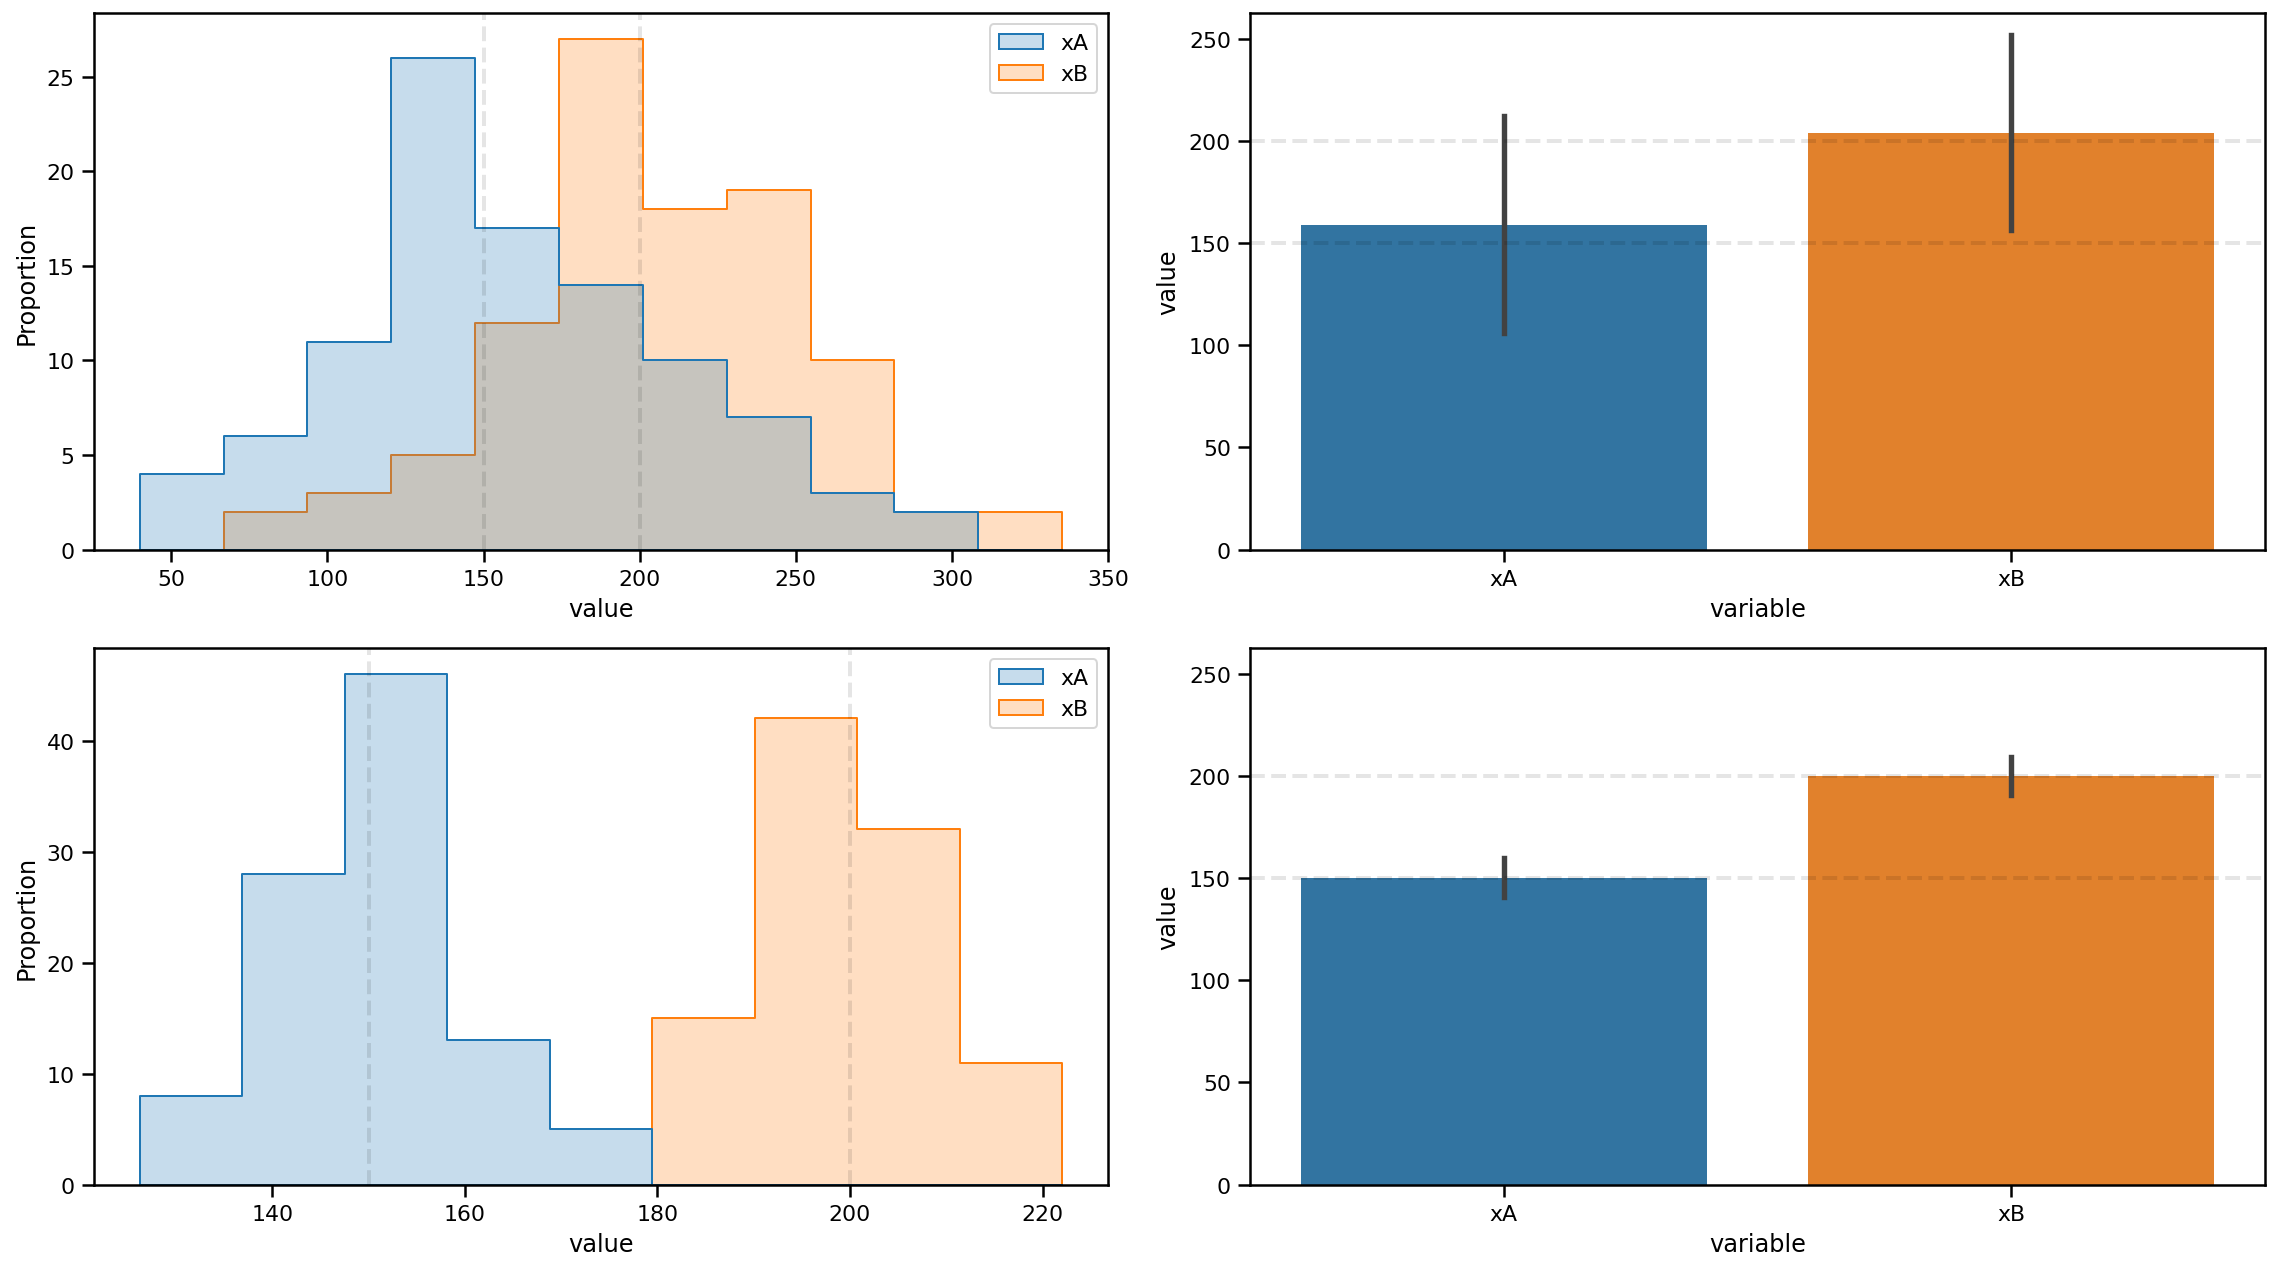

In [175]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))

# For each dataset (containing each two samples)
datasets = dataset_large_sd, dataset_small_sd
for i in range(len(datasets)):
    
    # Get data
    df = datasets[i]

    # Create histograms
    ax = axes[i, 0]
    sns.histplot(data=df, ax=ax, kde=False, element="step")
    
    # Plot the theoretical mean
    ax.axvline(mu_A, ls='--', color='black', alpha=0.1, lw=2)
    ax.axvline(mu_B, ls='--', color='black', alpha=0.1, lw=2)
    
    # Set the axis lables
    ax.set_ylabel("Proportion")
    ax.set_xlabel("value")

    # Create a barplot
    ax = axes[i, 1]
    df = df.melt()
    sns.barplot(x="variable", y="value", ax=ax, data=df, ci="sd")
    
    # Add horizontal lines representing the means
    ax.axhline(mu_A, ls='--', color='black', alpha=0.1, lw=2)
    ax.axhline(mu_B, ls='--', color='black', alpha=0.1, lw=2)
    
    # Set the y limits
    ax.set_ylim(0, max(mu_A, mu_B) + large_sd * 1.25)

plt.tight_layout()
plt.show()

#### What are we looking for?<a class="tocSkip"></a>

<div class="alert alert-block alert-info">
We want to test if the population mean of $x_A$ is likely to be the same as the population mean of $x_b$.
 </div>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>    
Differentiate:
<ul>
<li> <b>sample</b> mean: what we observed in our (possibly small) sample</li>
<li> <b>population</b> mean: what the mean would be if we'd measure it taking all the individuals of the population the sample belongs to.</li>
</ul>
</div>

Note that we assume here that both $x_A$ and $x_B$ are normally distributed, that is that the data come from a <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distribution</a>. More on this later...

#### Run test <a class="tocSkip"></a>

Let's see what happens for the dataset with small standard deviation.

In [176]:
# Run a Student's t-test
t, p = stats.ttest_ind(dataset_small_sd.xA, dataset_small_sd.xB)

# Print the results
print(f"t={t}, p={p}")

t=-36.785349613503, p=1.8931822436051005e-90


<div class="alert alert-block alert-info">
The result of a t-test includes two element: the <b>value of the t statistic</b>, the <b>p-value</b>. The focus is often on the $p$-value. 
    
We consider as starting point a <a href="https://en.wikipedia.org/wiki/Null_hypothesis">null hypothesis</a>. In the context of mean comparison (like here), it is equivalent to say "there is <b>no difference</b> between the means of the <b>parent populations</b>".
    
The <a href="https://en.wikipedia.org/wiki/P-value"><i>p</i>-value</a> is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. If the p-value is very small, then either the null hypothesis is false or something unlikely has occurred; what is equivalent to say: "it is likely that there is also a difference if we were looking at the parent populations". 
    
Said differently, the <b>p-value can be considered to be the probability to make a mistake by rejecting the null hypothesis</b> (more on this in the next section).
</div>

Here, the p-value is very small ($p=0.000 \dots 1$), what means that it is quite likely that there is a difference in the parent population (and we know that it is indeed the case as we generate the data ourselves).

Let's look of what happens for dataset with large standard deviation:

In [177]:
# Run a Student's t-test
t, p = stats.ttest_ind(dataset_large_sd.xA, dataset_large_sd.xB)

# Print the results
print(f"t={t}, p={p}")

t=-6.2698379730170615, p=2.2209697178288552e-09


Both p-values are very small, indicating that the probability to make a mistake by rejecting the null-hypothesis is small.

> It turns out that the $n$ is so large, that the difference between the two means is also statistically significant in the dataset with large variance. **Inferential statistics are a good tool to know if we could generalize what we observed** (SD/variance)!

# The p-value as the probability to make a mistake by rejecting the null hypothesis

<div class="alert alert-block alert-info">
The <b>p-value can be considered to be the probability to make a mistake by rejecting the null hypothesis</b>. In a <a href="https://en.wikipedia.org/wiki/Frequentist_probability">frequentist</a> point of view, a probability can be assimilated to a frequency. If so, let's find a small experiment where I generate data, such that the frequency of my observation matches (or at least is proportional) to the $p$-value. 
</div>

So let's simulate and see how often I could be wrong...

#### Generate data <a class="tocSkip"></a>

Let's construct two samples $x_1$ and $x_2$, such that $\bar x_1 > \bar x_2$ (with $\bar x$: the observed mean for $x$), even if $\mu_{x_1} = \mu_{x_2}$ (with $\mu_x$: the theoretical/parent population mean).

In [178]:
# Seed the random number generator
np.random.seed(1234)

# Set the parameters
n = 100
mu = 100
sigma = 30

# Generate two samples
xA = np.random.normal(mu, scale=sigma, size=n)
xB = np.random.normal(mu, scale=sigma, size=n)

if np.mean(xA) > np.mean(xB):
    x1 = xA
    x2 = xB
else:
    x1 = xB
    x2 = xA

# Look at the data
df = pd.DataFrame(data={"x1": x1, "x2": x2})
df

,x1,x2
0,114.143055,108.736161
1,64.270729,116.996011
2,142.981209,115.107753
3,90.620443,108.558871
4,78.382338,114.528643
...,...,...
95,97.541588,87.053515
96,89.657020,95.165893
97,115.848644,126.674725
98,67.930336,108.651305


In [179]:
print(f"mean x1: {np.mean(df.x1)}")
print(f"mean x2: {np.mean(df.x2)}")

mean x1: 101.05336849376309
mean x2: 98.49537630605201


#### Visualize data <a class="tocSkip"></a>

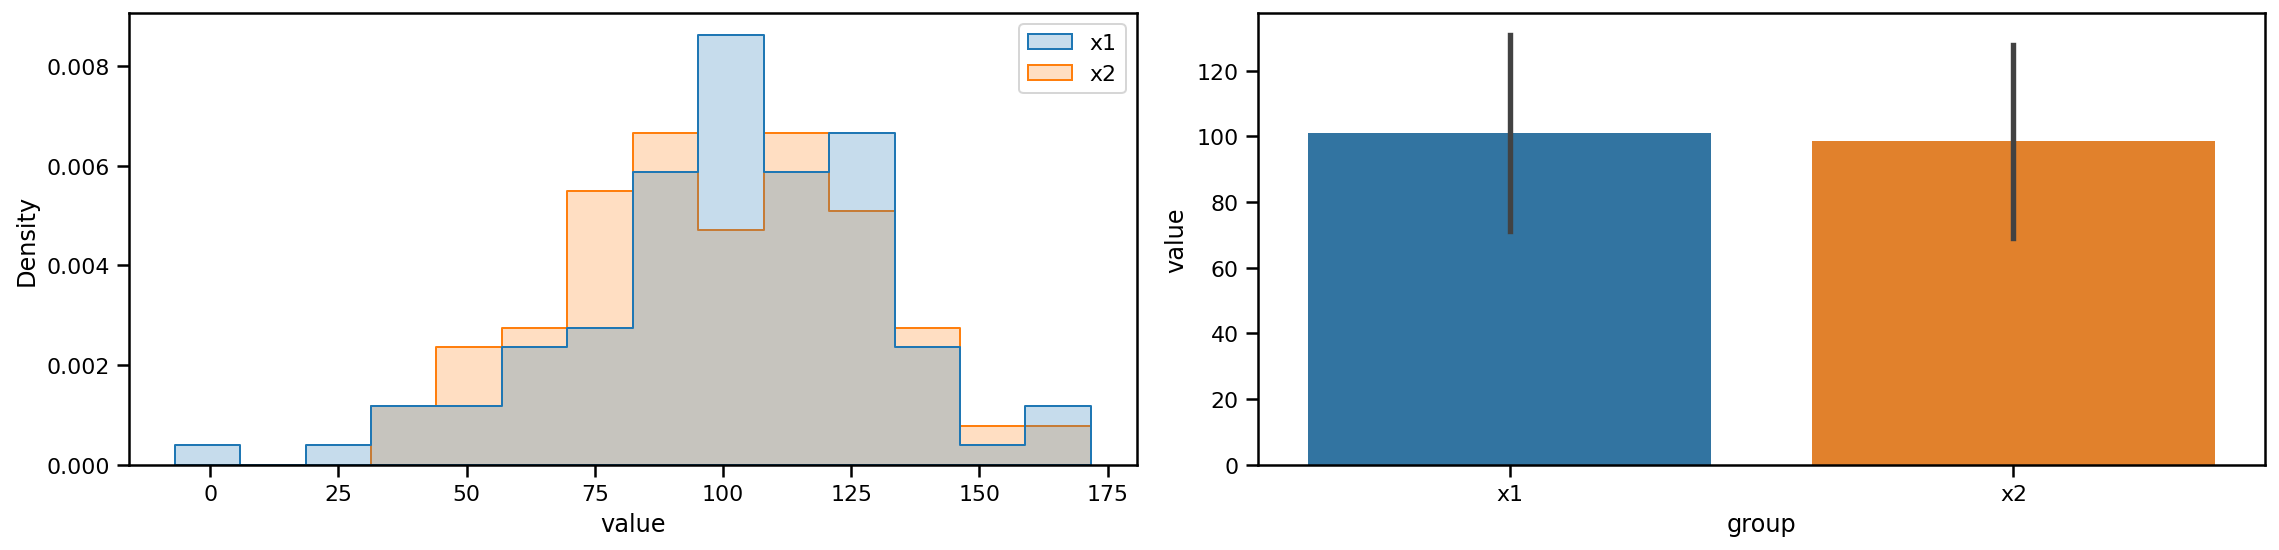

In [180]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))

# Create the histograms
sns.histplot(data=df, ax=ax1, 
             element="step",
             stat="density")  # y-axis is density instead of counts

# Put labels
ax1.set_ylabel("Density")
ax1.set_xlabel("value")

# Plot the barplot
df_melted = df.melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax2, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [181]:
# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the results
print(f"t = {t}, p = {p}")

t = 0.6077059889717964, p = 0.5440788547965428


Note that as expected, the p-value is really high (suggesting that the probability of making a mistake by rejecting the null-hypothesis is really high). Indeed, even if our samples, we observe that $\bar x_1 > \bar x_2$, the theoretical mean of both samples is the same (by construction).

#### Reproduce test result<a class="tocSkip"></a>

...by looking at which <b>frequency I observe the inverse difference</b>, that is $\bar x_2 > \bar x_1$ instead of $\bar x_1 > \bar x_2$, creating new datasets using as theoretical means the means observed in the samples, and as theoretical SD the SD observed in the samples.

In [182]:
# Compute the observed means for the two samples
mu1 = np.mean(x1)
mu2 = np.mean(x2)

# Compute the observed standard deviations for the two samples
sigma1 = np.std(x1)  
sigma2 = np.std(x2)

In [183]:
# Set the parameters
n_dataset = 10000

# Container for the results 
mu2_sup_mu1 = np.zeros(n_dataset)

# Create data for each dataset
for i in range(n_dataset):
    
    # Create two samples using parameters observed in the sample, and of the same size 
    new_x1 = np.random.normal(mu1, scale=sigma1, size=n)  
    new_x2 = np.random.normal(mu2, scale=sigma2, size=n)
    
    # Look if observed mean for sample 2
    # is superior for sample 1
    r = np.mean(new_x2) > np.mean(new_x1)
    
    # Store the result 
    mu2_sup_mu1[i] = r

# Compute the frequence with which 
# 'inverse' difference is observed
err_freq = np.mean(mu2_sup_mu1)

#### Visualize the results <a class="tocSkip"></a>

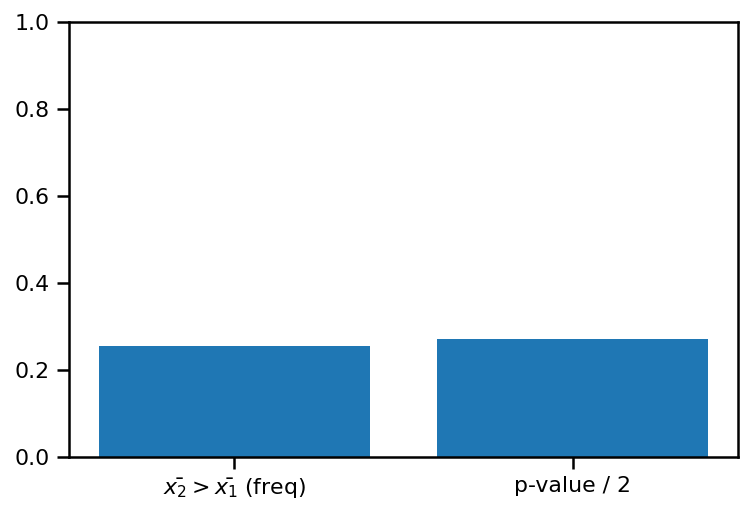

In [184]:
# Create figure and axis
fig, ax = plt.subplots()

# Define labels
labels = [r'$\bar{x_2} > \bar{x_1}$ (freq)', "p-value / 2"]

# Defines values
values = [err_freq, p/2]

# Create barplot
ax.bar(labels, values)

# Set the limit of the y-axis
ax.set_ylim(0, 1.0)

plt.show()

# The significance threshold(s)

In human/animal related studies (but not only), $p=0.05$ (5% error), what means that a test result can be said **significant** if the $p$-value is below $0.05$.

<img src="img/p005.jpg" width="600">

Note that it is before all a **convention**.

# I got it wrong: Error type I and Error type II

 || Null hypothesis is true | null hypothesis is false |
|--- | --- | ----------- |
|**Reject null hypothesis**| False positive [**Type I error**] | true negative |
|**Do not reject null hypothesis** | True positive | False negative [**Type II error**] |

<img src="img/classification.png" width="300">

Sensitivity $= \frac{TP}{TP + FN}$ ("don't miss someone positive")

Specificity = $\frac{TN}{TN + FP}$ ("don't select someone negative")

Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ ("do good predictions overall")

Precision = $\frac{TP}{TP + FP}$ ("don't be too inclusive")

## Error type I: False positive <a id="S4.1">

<div class="alert alert-block alert-info">

<b>False positive</b>: A result of a diagnostic test or procedure that wrongly indicates the presence of a disease or other condition.
[<a href="https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095809504">Oxford Reference</a>]
<br>
<br>
...in our context: the test result indicates a significant difference while it was actually no difference in the parent populations.
</div>

Let's take an example...

#### Generate data <a class="tocSkip"></a>

In [185]:
# Seed the random number generator
np.random.seed(46)

# Set the parameters
mu = 100
sig = 10
n = 20

# Generate two samples
x1 = np.random.normal(mu, scale=sig, size=n)
x2 = np.random.normal(mu, scale=sig, size=n)

# Look at the data
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,105.848758,98.648677
1,112.311957,95.216593
2,108.219003,84.050250
3,92.007716,91.310407
4,104.120532,99.672772
5,98.238434,84.725685
6,99.268280,98.754019
7,94.343336,97.380508
8,99.065348,109.953512
9,108.573011,103.175434


#### Compute sample means <a class="tocSkip"></a>

In [186]:
mean_x1 = np.mean(df.x1)
mean_x2 = np.mean(df.x2)

print(f"sample mean x1: {mean_x1}")
print(f"sample mean x2: {mean_x2}")

sample mean x1: 101.56887516675758
sample mean x2: 96.09697686169982


Note that the sample means are different even if the population mean is the same (`mu=100`).

#### Visualize data <a class="tocSkip"></a>

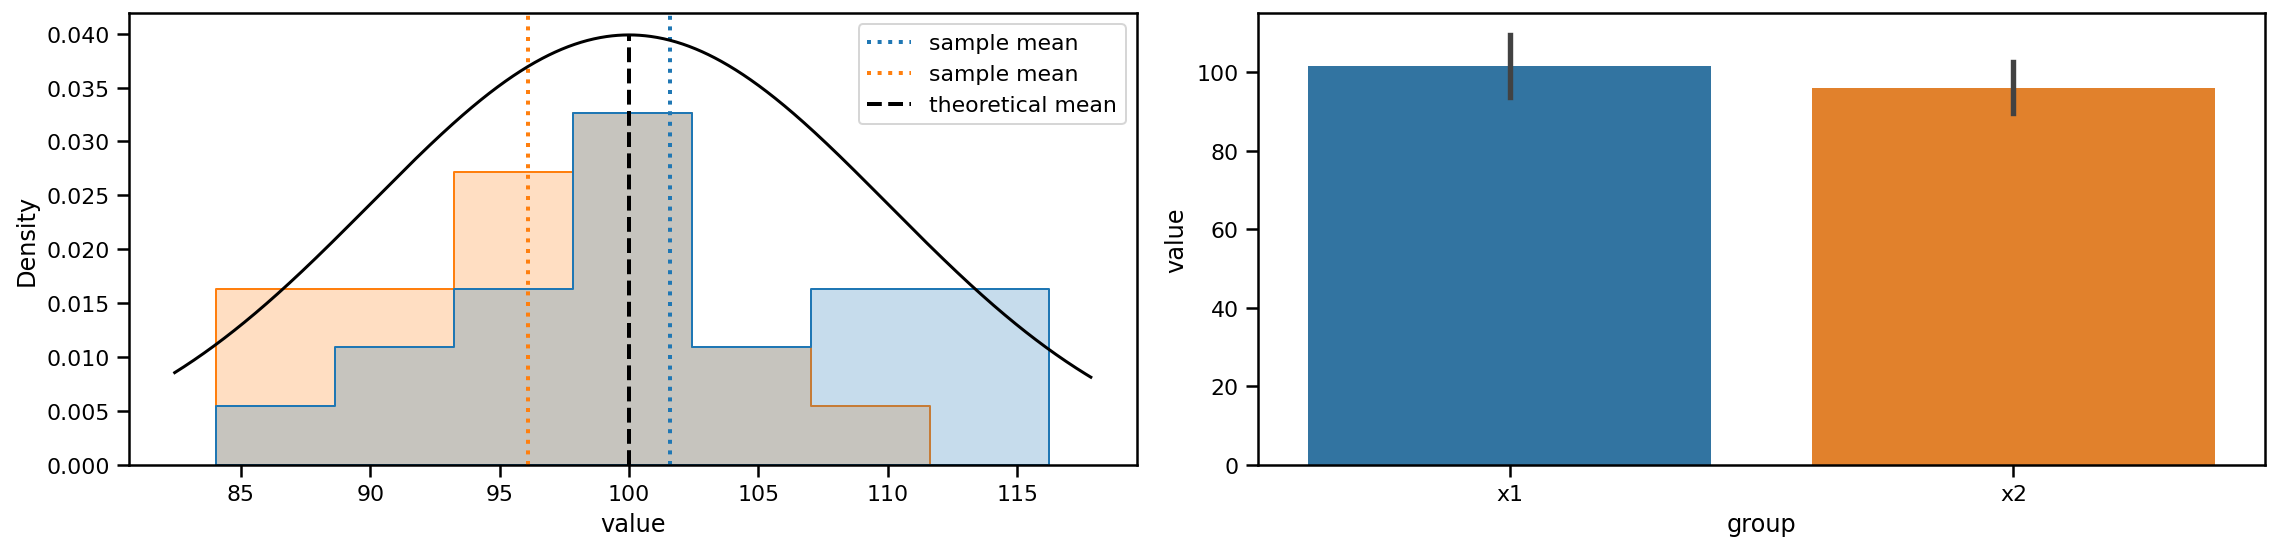

In [187]:
# Create the fig and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

# Do the histogram
ax = axes[0]
sns.histplot(df, ax=ax, stat="density", element="step")

# Create the lines indicating the means
ax.axvline(mean_x1, label="sample mean", color='C0', lw=2, ls=':')
ax.axvline(mean_x2, label="sample mean", color='C1', lw=2, ls=':')

# Create the bell curve corresponding to the theoretic distribution
x_min, x_max= ax.get_xlim()
x_th = np.linspace(x_min, x_max, 1000)
y_th = stats.distributions.norm.pdf(x_th, loc=mu, scale=sig)
ax.plot(x_th, y_th, color="black")

# Create the line for the theoretical mean
ymax = stats.distributions.norm.pdf(mu, loc=mu, scale=sig)
ax.vlines(mu, ymin=0, ymax=ymax, 
          label="theoretical mean", color='black', lw=2, ls='--')

# Set the axis labels
ax.set_ylabel("Density")
ax.set_xlabel("value")

# Create the legend
ax.legend()

# Do the barplot
ax = axes[1]
df_melted = df.melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [188]:
# Set the threshold 
thr = 0.05

# Run the Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the results
print(f"t={t}, p={p}, can reject null hypothesis={p < thr}")

t=2.324641079949218, p=0.025533350157787085, can reject null hypothesis=True


Result indicates that we can reject the null-hypothesis (and saying something like 'there is a difference'), while we should not do so (we know by construction that $x_1$ and $x_2$ come from the same distribution, and therefore that the population mean of the two samples is the same): it is a **false positive**.

## Error type II: False negative <a id="S4.2">

<div class="alert alert-block alert-info">

<b>False negative</b>: A result of a diagnostic test or procedure that wrongly indicates the absence of a disease or other condition.
[<a href="https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095809486">Oxford Reference</a>]
<br>
<br>
...in our context: the test result indicates a non-significant difference while they were actually a difference in the parent populations.
</div>

Let's take an example...

#### Generate data <a class="tocSkip"></a>

In [189]:
# Seed the random number generator
np.random.seed(0)

# Set the parameters
m1, m2 = 0, 1
sig = 0.9
n = 20

# Generate two samples
x1 = np.random.normal(m1, scale=sig, size=n)
x2 = np.random.normal(m2, scale=sig, size=n)

# Look at the data
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,1.587647,-1.297691
1,0.360141,1.588257
2,0.880864,1.777993
3,2.016804,0.332051
4,1.680802,3.042779
5,-0.879550,-0.308929
6,0.855080,1.041183
7,-0.136221,0.831535
8,-0.092897,2.379501
9,0.369539,2.322423


#### Visualize data <a class="tocSkip"></a>

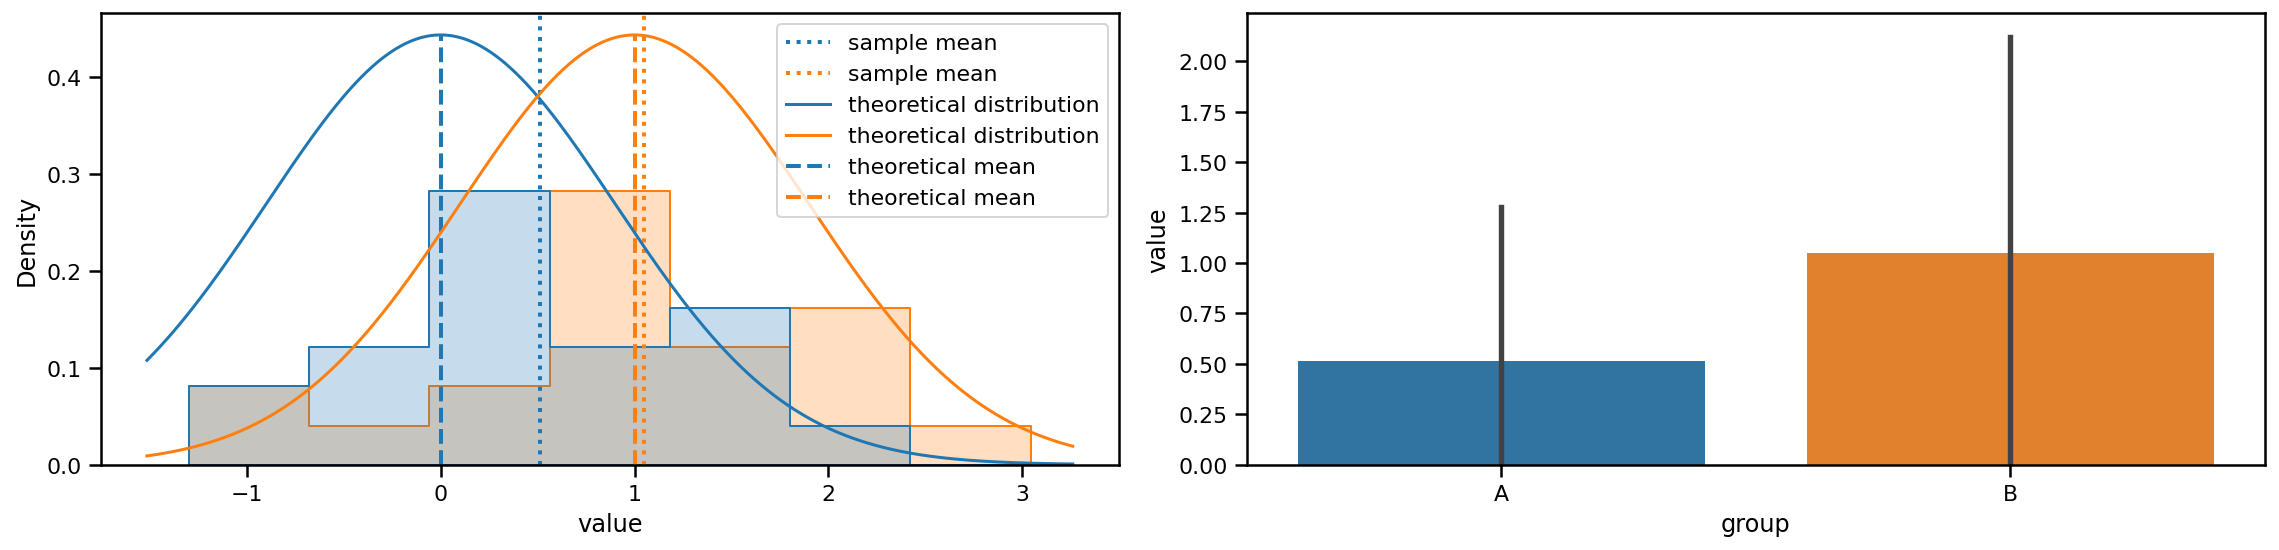

In [190]:
# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ax = axes[0]

# Plot the histogram
sns.histplot(df, ax=ax, stat="density", element="step")

# Plot the sample means
ax.axvline(np.mean(df.x1), label="sample mean", color='C0', lw=2, ls=':')
ax.axvline(np.mean(df.x2), label="sample mean", color='C1', lw=2, ls=':')

# Plot the bell curves
x_min, x_max= ax.get_xlim()

# Plot the theoretic distributions for the two samples
for m, color in (m1, "C0"), (m2, "C1"):
    
    # Plot the line for the mean
    ymax = stats.distributions.norm.pdf(m, loc=m, scale=sig)
    ax.vlines(m, ymin=0, ymax=ymax,transform=ax.transData,
              label="theoretical mean", color=color, lw=2, ls='--')
    
    # Plot the bell curve
    x_th = np.linspace(x_min, x_max, 1000)
    y_th = stats.distributions.norm.pdf(x_th, loc=m, scale=sig)
    ax.plot(x_th, y_th, color=color, label="theoretical distribution", ls='-')

# Create the axis labels 
ax.set_ylabel("Density")
ax.set_xlabel("value")

# Create the legend
ax.legend()

# Plot the barplot
ax = axes[1]
df = pd.DataFrame({"A": x1, "B": x2}).melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax, data=df, ci="sd")

# Set the y-axis limits
ax.set_ylim(0, ax.get_ylim()[-1])

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [191]:
# Set the threshold
thr = 0.05

# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the result
print(f"t={t}, p={p}, can reject null hypothesis={p < thr}")

t=-1.7830545865581873, p=0.08256721720461004, can reject null hypothesis=False


Result indicates that we can not reject the null-hypothesis (and saying something like 'there is no significant difference'), while we should do so (we know by construction that $x_1$ and $x_2$ do not come from the same distribution): it is a **false negative**.

#### To remember <a class="tocSkip"></a>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>
Do not confound <b>samples</b> mean (standard deviation) with <b> population</b> mean (standard deviation): the discrepancy between both is the cause of the false negatives and false positives!
</div>

# Case study: Mean comparison using Student's t-test<a id="S5"></a>

Original article: <a href="https://doi:10.1093/biomet/6.1.1">Student" William Sealy Gosset (1908). "The probable error of a mean". Biometrika. 6 (1): 1–25</a>.

<img src="img/William_Sealy_Gosset.jpg">
<center>William S. Gosset or "Student"</center>

<img src="img/magic.jpg">

Let's reveal the magic trick behind the p-value...

## Conditions of application

For the magic to operate, some conditions need to me be met.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>

Note that for computing a Student t-test, the following conditions about the distribution in the parent population need to be met:

<ul>
    <li><b>Normality</b>: The distributions from which the samples are drawn are <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distributions</a>.</li>
<li><b>Homogeneity of variances</b>: The variance of the distribution from which samples are drawn are approximately equal.</li>
</ul>

Furthermore, the following conditions about the samples need to be met:
<ul><li><b> Equal size of sample </b>: Both samples are of the same size.</li></ul>
   
</div>

Let's come back on this in the next section.

## Compute the t-statistic

### Formula

The t statistic can be calculated as follows:

$$ t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{p}{\sqrt {\frac {2}{n}}}}}$$
where $n = n_1 = n_2$ and $s_p$ is the pooled standard deviation of the two samples. 

Note that:
* The numerator of $t$ is the difference between two means
* The denominator of $t$ is the standard error of the difference between the two means.

The pooled standard deviation of the two samples $X_1$ and $X_2$, noted $s_p$, is defined as:

$$ s_{p}={\sqrt {\frac {s_{X_{1}}^{2}+s_{X_{2}}^{2}}{2}}} $$
with $s_{X_1}^2$ and $s_{X_2}^2$ are the unbiased estimators of the variances of $X_1$ and $X_2$.
 
The unbiased estimator of variance for a sample $X$ is defined as:

$${s_{X=[x_1, ..., x_n]}^{2}= {\frac {1}{n-1}}\sum _{i=1}^{n}\left(x_{i}-{\overline {X}}\right)^{2}}$$

#### Unbiased vs biased estimator <a class="tocSkip"></a>

The bias of an estimator is the difference between this estimator's expected value and the true value of the parameter being estimated. (you can look on the <a href="https://en.wikipedia.org/wiki/Bias_of_an_estimator">Wikipedia page</a> on this). 

We divide by $n-1$ (instead of $n$) when computing the unbiased estimator of variance, because $n-1$ is the number of degrees of freedom (short intuition below; you can also watch <a href="https://www.khanacademy.org/math/ap-statistics/summarizing-quantitative-data-ap/more-standard-deviation/v/review-and-intuition-why-we-divide-by-n-1-for-the-unbiased-sample-variance">this short video</a> on Khan Academy).

#### Intuition on degrees on freedom <a class="tocSkip"></a>

What are degrees of freedom?

>We know that the the sum of deviations around any mean must equal zero. 

>Therefore for any variable, if the mean is known and the first $n-1$ observations are known, then the $n^{th}$ observation must be the value that causes the sum of all the deviations around the mean to equal zero. 

>$n-1$ is called the degrees of freedom because the first $n-1$ observations have the <b>freedom</b> to be any value they want to be, but the $n^{th}$ value has no freedom. It must be whatever value that forces the sum of deviations around the mean to equal zero. 

From a discussion on <a href="https://www.khanacademy.org/math/statistics-probability/confidence-intervals-one-sample/old-confidence-interval-videos/v/t-statistic-confidence-interval">Khan Academy</a>.

### Example

Let's take an example...

#### Generate data <a class="tocSkip"></a>

Let's generate two samples such that $\bar x_1$ < $\bar x_2$

In [192]:
# Set the random number generator
np.random.seed(1234)

# Set the parameters
n=20
mu1, mu2 = 100, 115
sigma = 30

# Generate two samples
x1 = np.random.normal(mu1, scale=sigma, size=n)
x2 = np.random.normal(mu2, scale=sigma, size=n)

# Make a few prints
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,114.143055,108.920610
1,64.270729,95.320920
2,142.981209,120.802641
3,90.620443,131.603167
4,78.382338,154.544547
5,126.614888,100.920841
6,125.787652,135.266623
7,80.904295,60.489183
8,100.470891,109.506744
9,32.719451,146.769076


In [193]:
print(f"mean x1: {df.x1.mean()}")
print(f"mean x2: {df.x2.mean()}")

mean x1: 99.66108268125693
mean x2: 124.42115761217228


#### Visualize data <a class="tocSkip"></a>

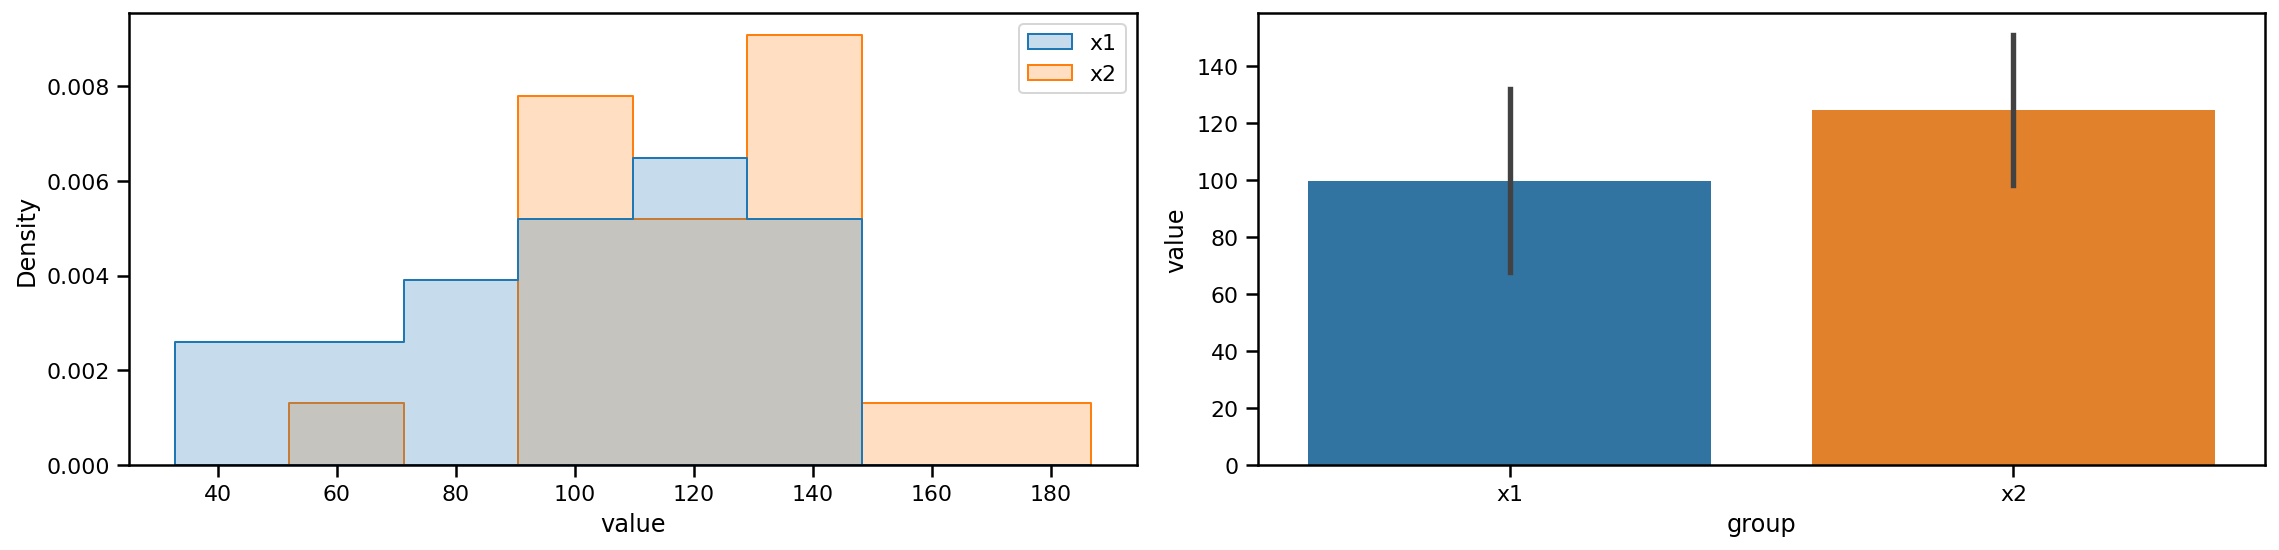

In [194]:
# Create the figure and the axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))

# Plot the histogram
sns.histplot(df, ax=ax1, 
             stat="density", # y-axis is density instead of counts
             element="step") # better visualization

# Set the axis labels
ax1.set_ylabel("Density")
ax1.set_xlabel("value")

# Plot the barplot
df_melted = df.melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax2, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

#### Run the test <a class="tocSkip"></a>

In [195]:
# Set the threshold
thr = 0.05

# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the result
print(f"t={t}, p={p}, can reject={p < thr}")

t=-2.591248617060576, p=0.013492277877684325, can reject=True


#### Redo the calculation by hand <a class="tocSkip"></a>

Let's compute it by hand:

[...] 

with $s_{X_1}^2$ and $s_{X_2}^2$ are the unbiased estimators of the variances of $X_1$ and $X_2$.
 
The unbiased estimator of variance for a sample $X$ is defined as:

$${s_{X=[x_1, ..., x_n]}^{2}= {\frac {1}{n-1}}\sum _{i=1}^{n}\left(x_{i}-{\overline {X}}\right)^{2}}$$
[...]

In [196]:
# Compute the unbiased estimators of the variance
var1 = np.var(x1, ddof=1)
var2 = np.var(x2, ddof=1)

# Make a few prints
print("var1", var1)
print("var2", var2)

var1 1092.6737289949485
var2 733.3891932316409


[...] 

The pooled standard deviation of the two samples $X_1$ and $X_2$, noted $s_p$, is defined as:

$${\displaystyle s_{p}={\sqrt {\frac {s_{X_{1}}^{2}+s_{X_{2}}^{2}}{2}}}.}$$
[...]

In [197]:
# Compute the pooled standard deviation of the two samples
sp = np.sqrt((var1 + var2)/2)

# Print the result
print("sp", sp)

sp 30.216410460431838


Now, we have everything we need to compute the t-test using the formula:

$$ t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{p}{\sqrt {\frac {2}{n}}}}}$$
[...]

In [198]:
# Compute the denominator
denom = sp * np.sqrt(2 / n)

# Compute the numerator
mean1 = np.mean(x1)
mean2 = np.mean(x2)
num = mean1 - mean2

# Compute the value of the t
t = num/denom

# Print the result
print("t", t)

t -2.5912486170605766


In [199]:
# Compute the value of the t
t = num/denom

# Print the result
print("t", t)

t -2.5912486170605766


#### Compare 'manual' result with Scipy result <a class="tocSkip"></a>

In [200]:
# Compare with the values used using Scipy
t, p = stats.ttest_ind(x1, x2, equal_var=True)
print("t", t)

t -2.591248617060576


## Compute the p-value

First thing that we need to compute the $p$-value is to look at the probability density function of $t$

### Formula: $t$-distribution PDF <a class="tocSkip"></a>

The <b>probability density function</b> (PDF) of the Student's t distribution is given by:
$$f(x) = \frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{x^2}{\nu} \right)^{-\frac{\nu+1}{2}}$$
where $\nu$  is the number of degrees of freedom for the $t$-statistic calculation (see below) and $\Gamma (\cdot)$ is the <a href="https://en.wikipedia.org/wiki/Gamma_function">gamma function</a>.

The <a href="https://stattrek.com/statistics/dictionary.aspx?definition=degrees-of-freedom">degrees of freedom</a> is equal $2n − 2$ where n is the number of participants in each group (to preserve the mean, each sample has $n-1$ degrees of freedom, so considering the two samples at once, we have $2(n-1) = 2 n - 2$).

#### Implementation <a class="tocSkip"> </a>

In [201]:
def t_pdf(x, degree_freedom):
    """
    This is equivalent to scipy.stats.t.pdf(x, df=degree_freedom)
    """
    # Shortcuts
    g = scipy.special.gamma
    nu = degree_freedom
    
    # Compute both left and right term
    left = g((nu+1)/2) / (np.sqrt(nu * np.pi)*g(nu/2))
    right = (1+x**2/nu) ** (-(nu+1)/2)
    
    # And multiply it
    result = left*right 
    return result

### Application to the running example <a class="tocSkip"></a>

#### Computing degrees of freedom <a class="tocSkip"></a>

Computing the number of degrees of freedom is quite straightforward...

In [202]:
# Compute the number of degrees of freedom
degree_freedom = 2*n - 2

# Print the result
print("degrees of freedom:", degree_freedom)

degrees of freedom: 38


#### Let's take a look at the PDF of $t$ <a class="tocSkip"></a>

Now, let's represent the probability density function of the t-distribution, given our specific number of degrees of freedom...

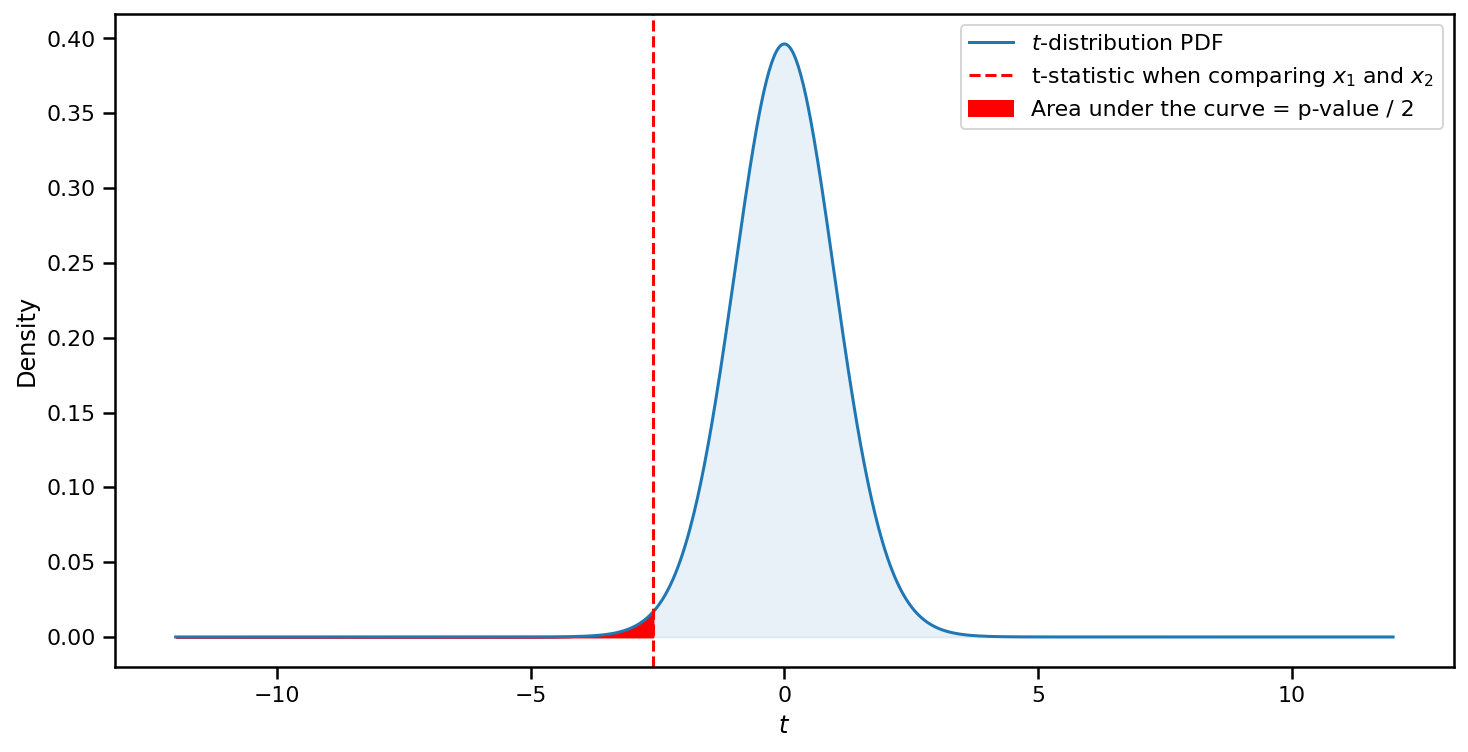

In [203]:
# Create the figure and the axis
fig, ax = plt.subplots(figsize=(12, 6))



# Plot the bell curve
x = np.linspace(-12, 12, 1000)
# Note that this can be shortened into 'y = stats.t.pdf(x, df=df)'
y = t_pdf(x, degree_freedom)
ax.plot(x, y, label="$t$-distribution PDF")

# Fill the area under the curve on the right of the t-value with blue
x_blue = np.linspace(t, 12, 1000)
y_blue = t_pdf(x_blue, degree_freedom)
ax.fill_between(x_blue, 0, y_blue, color="C0", alpha=0.1)

# Draw the line for representing the t-value
ax.axvline(t, ls='--', color="red", label="t-statistic when comparing $x_1$ and $x_2$")

# Fill the area under the curve on the left of the t-value with red
x_red = np.linspace(-12, t , 1000)
y_red = t_pdf(x_red, degree_freedom)
ax.fill_between(x_red, 0, y_red, color="red", label="Area under the curve = p-value / 2")

# Set the axis labels
ax.set_xlabel(r"$t$")
ax.set_ylabel("Density")

ax.legend()

plt.show()

The p-value one sided correspond to the area under the curve after the t-value.

For computing the area under the curve, we need the primitive (antiderivative) of the PDF, that is to say the cumulative distribution function (CDF)...

### $t$-distribution CDF <a class="tocSkip"></a>

#### Formula <a class="tocSkip"></a>

The <b>cumulative distribution function</b> is given by:
$$
     F(x) = \frac{1}{2} + x \Gamma \left( \frac{\nu+1}{2} \right)  \times
     \frac{\,_2F_1 \left ( \frac{1}{2},\frac{\nu+1}{2};\frac{3}{2};
           -\frac{x^2}{\nu} \right)}
     {\sqrt{\pi\nu}\,\Gamma \left(\frac{\nu}{2}\right)}$$
where $_2F_1$ is the <a href="https://en.wikipedia.org/wiki/Hypergeometric_function">hypergeometric</a> function.

#### Implementation <a class="tocSkip"> </a>

Let's skip the implementation for this one! Let's use instead SciPy (`scipy.stats.t.cdf` )!

#### Let's take a look at the CDF of $t$ now <a class="tocSkip"></a>

Let's represent the cumulative distribution function...

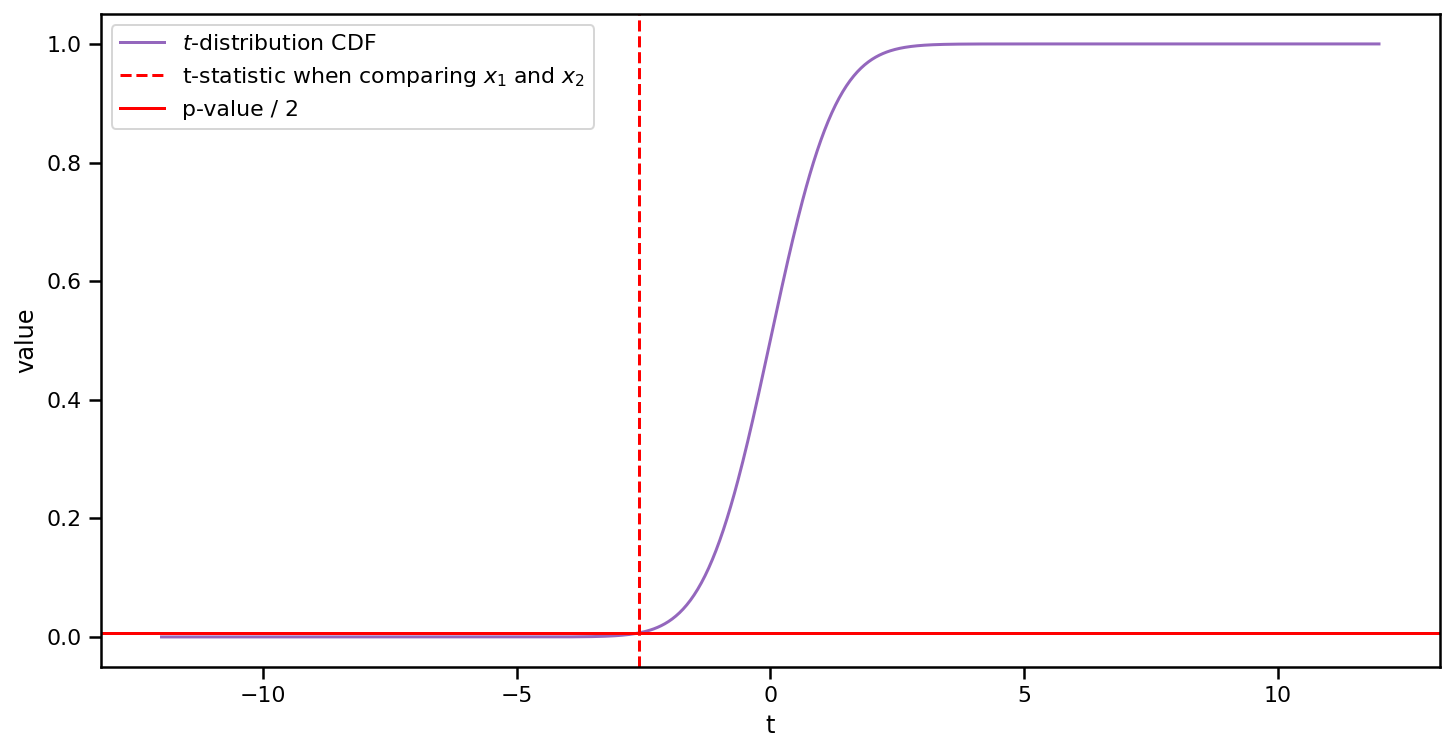

In [204]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative distribution functiion
x = np.linspace(-12, 12, 1000)
y1 = stats.t.cdf(x, degree_freedom)
ax.plot(x, y1, label="$t$-distribution CDF", color="C4")

# # Plot the survival function (1 - CDF)
# ax.plot(x, 1 - y1, label="1 - CDF", color="C1")

# Plot the line representing the t-value
ax.axvline(t, ls='--', color="red", label="t-statistic when comparing $x_1$ and $x_2$")
ax.axhline(stats.distributions.t.cdf(t, degree_freedom), 
           ls='-', color="red", label="p-value / 2")

# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("value")

# Create the legend
ax.legend()

plt.show()

### Compute the p-value <a class="tocSkip"></a>

Now, let's compute the p-value. 

It is finally quite easy now, we just need to look at CDF for the specific $t$-statistic that we obtained when comparing our two samples, and multiply by 2 (why to multiply by 2? we reply to this question just after)

In [205]:
# Compute the p-value
half_p = stats.distributions.t.cdf(t, degree_freedom)
p = half_p * 2

# Print the result
print("p", p)

p 0.013492277877684325


#### Compare with SciPy result <a class="tocSkip"></a>

In [206]:
# Compute the p-value using Scipy and compare...
t, p = stats.ttest_ind(x1, x2)
print("p", p)

p 0.013492277877684325


### Recommended reading <a class="tocSkip"> </a>

For further explanation on the computation of the p-value, you can refer to: <a href="https://doi.org/10.1038/nmeth.2698">Krzywinski, M., Altman, N. Significance, P values and t-tests. Nat Methods 10, 1041–1042 (2013).</a>

## One-sided vs two-sided

We talk about 'one-sided' when we consider the area under the PDF curve on one side, and about 'two-sided' because you take the value under the curve on both sides.

Let's represent that graphically...

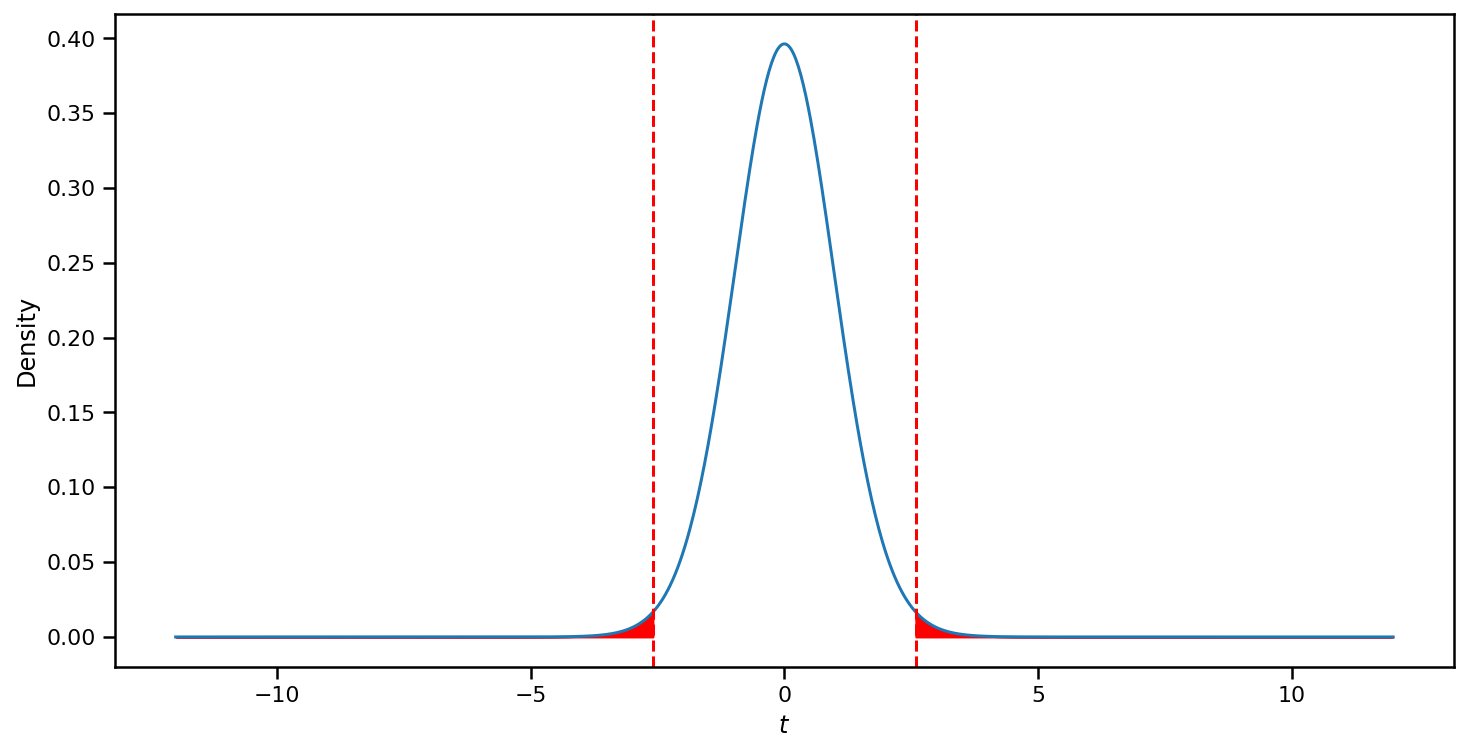

In [207]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define x-limits 
min_x, max_x = -12, 12

# Plot the bell curve
x = np.linspace(min_x, max_x, 1000)
y = stats.t.pdf(x, df=degree_freedom)  # Now, using the function provided by Scipy
ax.plot(x, y)

# Set the axis labels
ax.set_xlabel(r"$t$")
ax.set_ylabel("Density")

# Fill the area under the curve
for t_ in (t, -t):
    if t_ > 0:
        x = np.linspace(t_, max_x, 1000)
    else:
        x = np.linspace(min_x, t_, 1000)
    y_f = stats.t.pdf(x, df=degree_freedom)
    ax.fill_between(x, 0, y_f, color="red")
    
    # Draw a line corresponding to the t-value
    ax.axvline(t_, ls='--', color="red")

plt.show()

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
<b>Two-sided</b> is <b>more conservative</b> than one sided (you should by default use a two-sided, except if you have strong reason to not do so).
</div>

## The number of subjects matters

<div class="alert alert-block alert-info">

<b>The less subjects, the higher the <i>p</i>-value.</b>
</div>

Let's the see how the p-value for a given t-value change depending on the number of subjects...

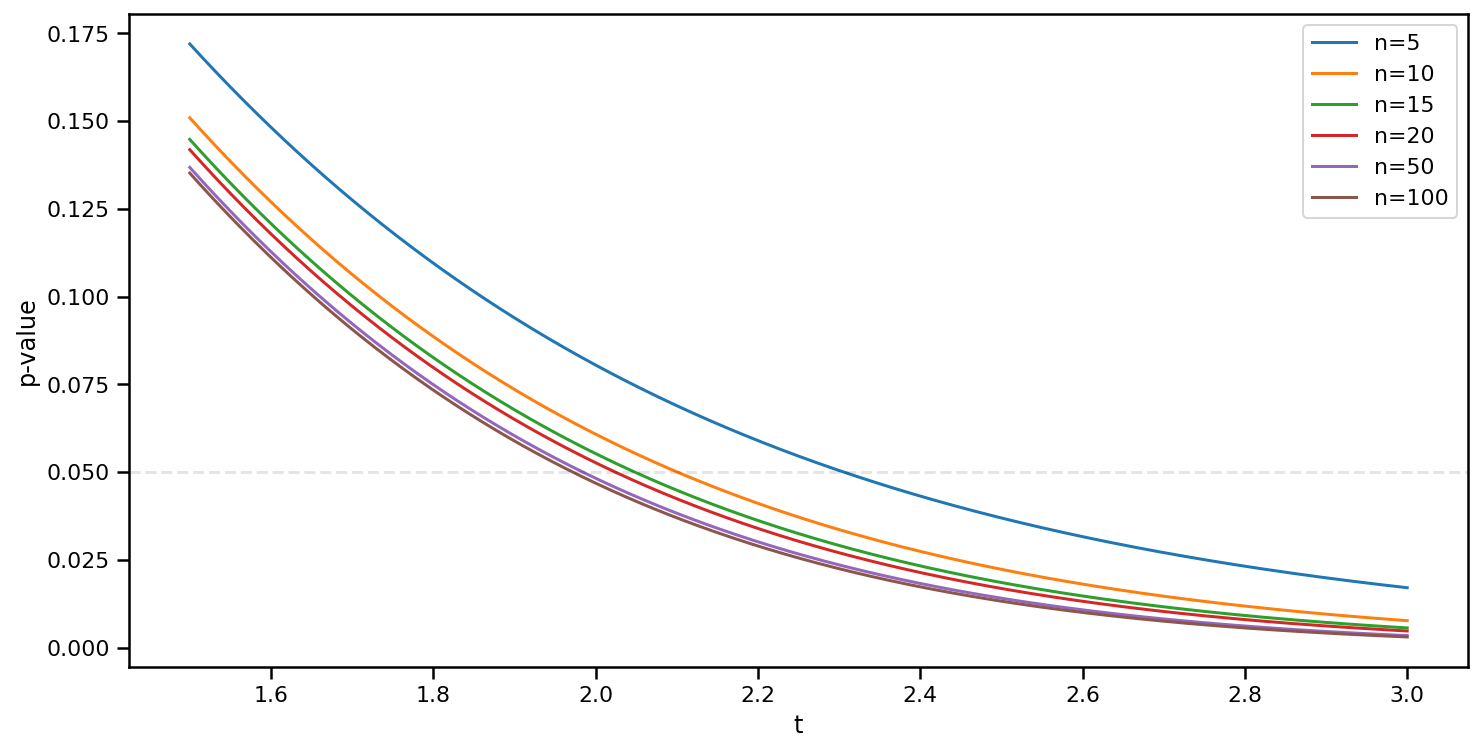

In [208]:
# Set the sample size to use
ns = [5, 10, 15, 20, 50, 100]

# Set the t-values to use
x = np.linspace(1.5, 3, 1000)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# For each n...
for n in ns:
    # Compute the number of degrees of freedom
    degree_freedom = 2*n - 2
    
    # Compute the CDF
    # Note that contrary to above, we consider here 1 - CDF 
    # because we consider positive values of the t-statistic.
    # You'll get positive values for t if you compare two samples, 
    # such that the first sample has the highest mean than the second has the lowest mean.
    # You'll get negative values for t if you compare two samples, 
    # such that the first sample has the lowest mean than the second has the highest mean.
    y = (1 - stats.distributions.t.cdf(x, degree_freedom)) * 2 
    
    # Plot the result
    ax.plot(x, y, label=f"n={n}")
    
# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("p-value")

# Create a line for the magic threshold
ax.axhline(0.05, ls='--', color="black", alpha=0.1)

# Create the legend
ax.legend()

plt.show()

The more you will increase your $n$, the more you will increase the probability to have significant results

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    Use a <b>number large enough of subjects</b> to avoid <b>false negatives</b>.
    </div>

# The condition of application of a statistical test: What alternatives to the t-test for mean comparison?

## Conditions of application of the t-test

### Look at the documentation

What we can see in the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html">doc</a> for the t-test's implementation from Scipy:

<img src="img/doc_t_test1.png" width="600" align="left">
<img src="img/doc_t_test2.png" width="600" align="left">
<img src="img/doc_t_test3.png" width="600" align="left">
<img src="img/doc_t_test4.png" width="600" align="left">

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>

Note that for computing a Student t-test, the following conditions about the distribution in the parent population need to be met:

<ul>
    <li><b>Normality</b>: The distribution from which the samples are drawn are <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distributions</a>.</li>
<li><b>Homogeneity of variances</b>: The variance of the distribution from which samples are drawn are approximately equal.</li>
</ul>

Furthermore, the following conditions about the samples need to be met:
<ul><li><b> Equal size of sample </b>: Both samples are of the same size.</li></ul>
   
</div>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test has often <b>conditions</b> of application relative to the <b>distribution</b> the data are assumed coming from. 
    </div>

### Checking whether the conditions of validity are met

Let's see with two samples how to test if they meet the requirements for comparing them with a Student's t-test:

In [209]:
# Seed the random number generator
np.random.seed(1285)

# Set the parameters
n = 100
mu1 = 10
mu2 = 20
sig = 10

# Generate the sample
x1 = np.random.normal(mu1, scale=sig, size=n)
x2 = np.random.normal(mu2, scale=sig, size=n)

Testing the size of sample is pretty straightforward...

In [210]:
# Test the equality of sample sizes
is_equal = len(x1) == len(x2)

# Print the result
print("is equal", is_equal)

is equal True


Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [211]:
# Run the  D’Agostino and Pearson’s test for sample x1
k, p = stats.normaltest(x1)

# Print the result
print(f"k={k}, p={p}")

k=1.5798844659411548, p=0.4538710133052598


In [212]:
# Run the  D’Agostino and Pearson’s test for sample x2
k, p = stats.normaltest(x2)

# Print the result
print(f"k={k}, p={p}")

k=0.9889358066077525, p=0.6098953442704012


Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html">Levene</a> test. The <b>null hypothesis</b> is that the <b>all samples are from populations with equal variances</b>.

In [213]:
# Run the Levene test
stat, p = stats.levene(x1, x2)

# Print the result
print(f"k={k}, p={p}")

k=0.9889358066077525, p=0.7942487504762309


## The number of subjects is not the same and/or variances are unequal: Welch's t-test

<div class="alert alert-block alert-info">

When the <b>number of subjects is not the same</b> and/or <b>variances are unequal</b>: you can use a  <b><a href="https://en.wikipedia.org/wiki/Welch%27s_t-test">Welch's t-test</a></b>.
</div>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>

Note that the <b>distributions</b> from which the samples are drawn are still expected to be <b>normal distributions</b>.
</div>

### Formula <a class="tocSkip"></a>

The Welch's t-test can be computed this way:

$${\displaystyle t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{\bar {\Delta }}}}}$$
where

$${\displaystyle s_{\bar {\Delta }}={\sqrt {{\frac {s_{1}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}}}.}$$

### Example <a class="tocSkip"></a>

In [214]:
# Seed the random number generator
np.random.seed(4)

# Set the parameters
m1, m2 = 100, 150
sd1, sd2 = 50, 10
n = 100

# Generate two samples
x1 = np.random.normal(m1, scale=sd1, size=n)
x2 = np.random.normal(m2, scale=sd2, size=n)

# Make a few prints
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,102.528085,157.382471
1,124.997567,156.507532
2,50.204553,156.147406
3,134.679925,148.734314
4,79.084924,165.788742
...,...,...
95,126.162383,150.494765
96,75.209074,147.386880
97,91.426770,158.767425
98,52.781570,145.171213


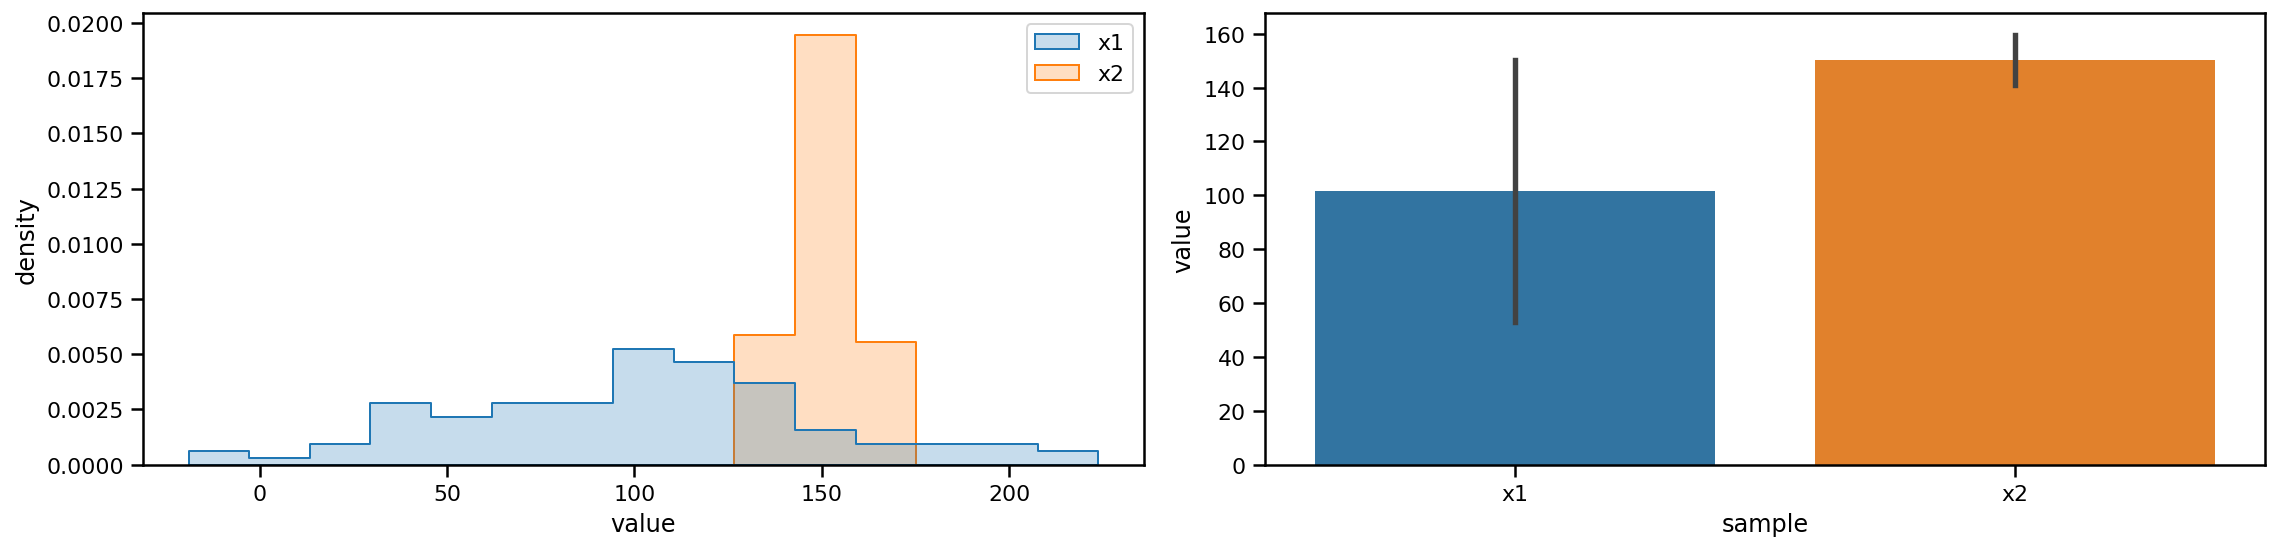

In [215]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

# Plot the histogram
ax = axes[0]
sns.histplot(data=df, ax=ax, stat="density", element="step")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

# Plot the barplot
ax = axes[1]
df_melted = df.melt(var_name="sample")
sns.barplot(x="sample", y="value", ax=ax, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

In [216]:
# Compute a Welch's t-test
# Note that the 'equal-var=False' that will force the use of a Welch's t-test 
# (instead of a Student t-test)
t, p = stats.ttest_ind(x1, x2, equal_var=False)

# Print the result
print(f"t={t}, p={p}")

t=-9.732916761113751, p=2.1823383644149874e-16


## The distribution is not (does not seem) normal: Mann-Whitney U test

<div class="alert alert-block alert-info">

 When the <b>distribution is <i>not</i> expected to be normal</b>, you can use a  <b><a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann-Whitney U test</a></b>.
   
</div>

Original article: <a href="doi:10.1214/aoms/1177730491">Mann, Henry B.; Whitney, Donald R. (1947). "On a Test of Whether one of Two Random Variables is Stochastically Larger than the Other". Annals of Mathematical Statistics. 18 (1): 50–60.</a> 

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
The Mann-Whitney is one type of <b>rank-dependent test</b>. What is common between the rank-dependent tests (also called non-parametric tests) is that they <b>don't make assumptions about the parent distributions</b>.
</div>

Why that? Because they rely on a technique based on ranking the values: you can learn more about that by looking at how to compute by hand the Mann-Whitney U in the Additional material.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
If you are not sure about the distribution your data are coming from, <b>rank-dependent tests</b> are a safe choice!
</div>

### Example <a class="tocSkip"></a>

##### Generate data <a class="tocSkip"></a>

We want data that are not normally distributed. Let's take the example of a gamma distribution (*we could have choose any other one, for instance the beta distribution, this is just an example, it doesn't matter which one we choose, it just does have to be NOT normal*).

So let's consider data following a <a href="https://en.wikipedia.org/wiki/Gamma_distribution">Gamma distribution</a>, that is such that:
$$ X \sim \mathrm{Gamma} (\alpha ,\beta )$$
with $\alpha, \beta \in \mathbb{R}$, two parameters.

*Note: the <a href="https://en.wikipedia.org/wiki/Gamma_distribution">gamma distribution</a> is something different than the gamma function (even if there is a connection: the PDF of the gamma distribution uses the gamma function).*

In [217]:
# Seed the random number generator
np.random.seed(124)

# Set the parameters
# From the doc of 'np.random.gamma': Samples are drawn from a Gamma distribution with specified parameters, 
# shape (sometimes designated “k”) and scale (sometimes designated “theta”), 
# where both parameters are > 0.
# knowing that shape=alpha and theta = 1/beta
k1, t1 = 1, 10
k2, t2 = 1.3, 14
n = 25

# Generate two samples
x1 = np.random.gamma(k1, scale=t1, size=n)
x2 = np.random.gamma(k2, scale=t2, size=n)

# Put it in a dataframe and display
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,1.121221,29.337056
1,13.683424,10.555135
2,8.493649,9.035222
3,6.129344,7.968024
4,4.856549,33.048903
5,3.201905,6.520517
6,11.025071,44.421122
7,5.033123,17.018304
8,3.306910,18.598031
9,15.137628,3.738932


##### Visualize data <a class="tocSkip"></a>

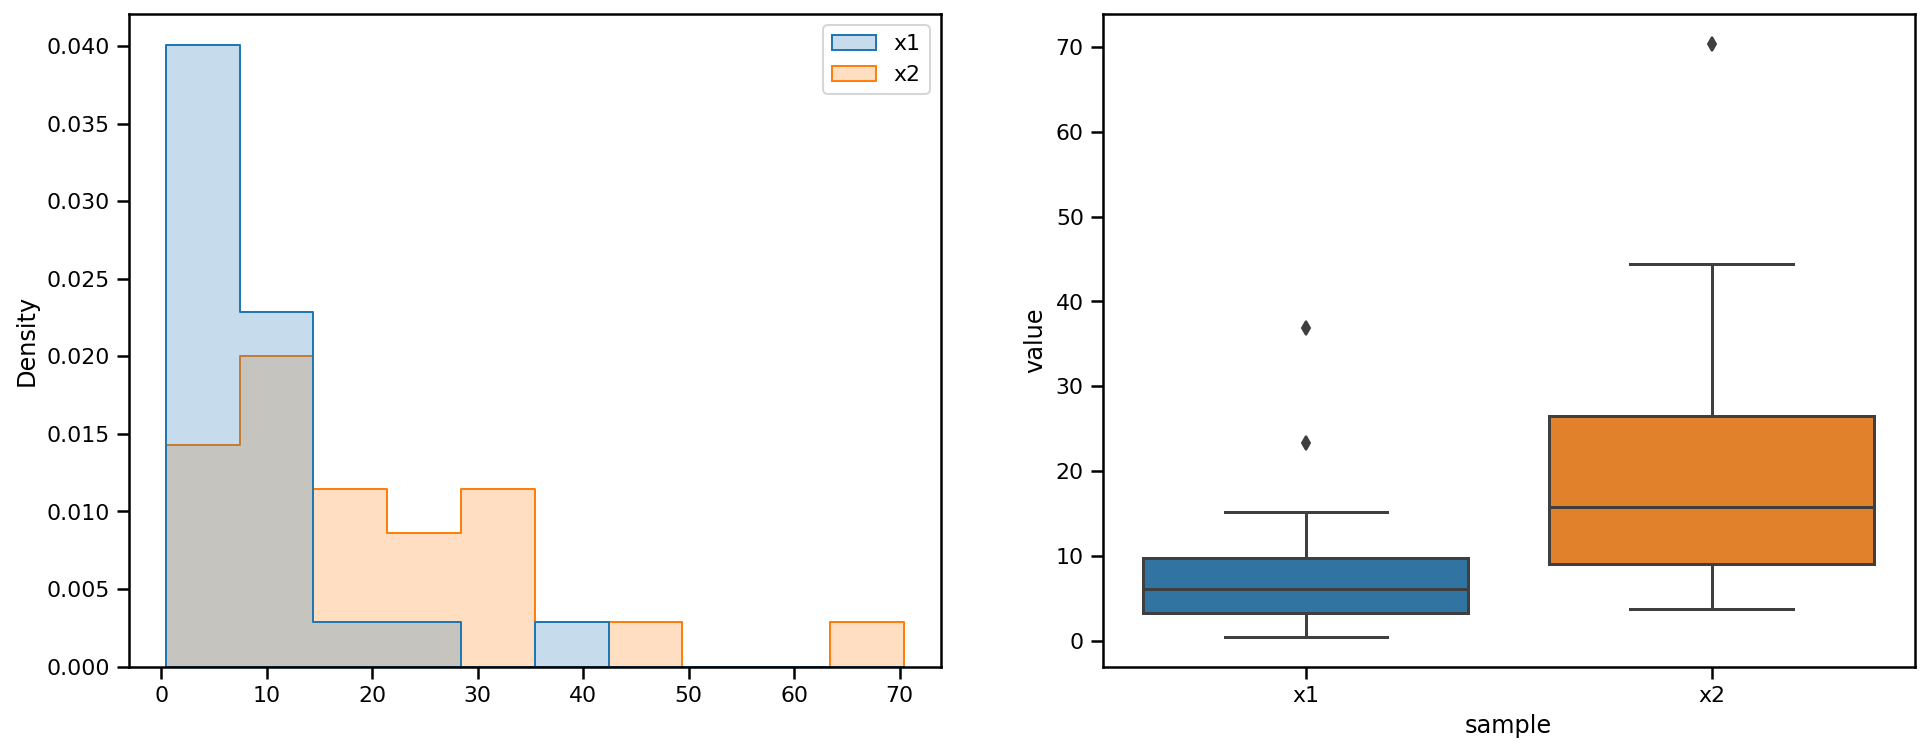

In [218]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the histogram
sns.histplot(data=df, ax=ax1,
             stat="density",
             element="step")

# Plot the boxplot
df_melted = df.melt(var_name="sample")
sns.boxplot(x="sample", y="value", ax=ax2, data=df_melted)

plt.show()

#### Computing the Mann–Whitney U <a class="tocSkip"></a>

In [219]:
# Compute the Mann-Whitney U
# Note: the default option is deprecated
# Remember to use the argument "alternative='two-sided'"
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')

# Print the results
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


### Remember to read the doc! <a class="tocSkip"></a>

Don't forget to read the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html">doc</a> for the conditions of application!

<img src="img/doc_mw1.png" width="600" align="left">
<img src="img/doc_mw2.png" width="600" align="left">
<img src="img/doc_mw3.png" width="600" align="left">

### Looking for more? <a class="tocSkip"></a>

They are one sections in the Additional material relating to the computation of the Mann-Whitney by hand. You'll see that it is quite different from the way to compute the $t$-test.

# Except mean comparison, for what can I use inferential statistics?

## I want to test the relation between two continuous variables: Correlation coefficient

...is probably what you're looking for.



### Pearson correlation coefficient

The Pearson correlation between $X$ and $Y$ can be expressed as:
$$r_{XY}= \frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {X}})(y_{i}-{\bar {Y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {X}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {Y}})^{2}}}$$

where $\overline {X}$ and $\overline {Y}$ are the means of $X$ and $Y$, and $s_{x}$ and $s_{y}$ are the corrected standard deviations of $X$ and $Y$.

Original article:  <a href="https://doi.org/10.1098/rspl.1895.0041">Pearson, Karl (1895). "Notes on regression and inheritance in the case of two parents". Proceedings of the Royal Society of London. 58: 240–242</a>.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>

Note that for applying a test based on a Pearson correlation, the following conditions about the parent distributions need to be met:
<ul>
<li><b>Normality</b>: The distribution from which the samples are drawn are <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distributions</a>.</li>
</ul>
    
</div>

#### Example <a class="tocSkip"></a>

##### Load the data <a class="tocSkip"></a>

In [220]:
# Import the data
df = pd.read_csv(os.path.join("data", "rr.csv"))

# Take a look
df

,Country,Year,Debt,Growth
0,Australia,1946,190.419080,-3.557951
1,Australia,1947,177.321371,2.459475
2,Australia,1948,148.929811,6.437534
3,Australia,1949,125.828699,6.611994
4,Australia,1950,109.809398,6.920201
...,...,...,...,...
1170,US,2005,62.766724,3.054518
1171,US,2006,63.489973,2.672807
1172,US,2007,63.985488,2.141613
1173,US,2008,74.091061,0.438166


Data from <a href="https://pubs.aeaweb.org/doi/pdf/10.1257/aer.100.2.573">Reinhart, C. M., & Rogoff, K. S. (2010). Growth in a Time of Debt. American economic review, 100(2), 573-78.</a>

##### Visualize data <a class="tocSkip"></a>

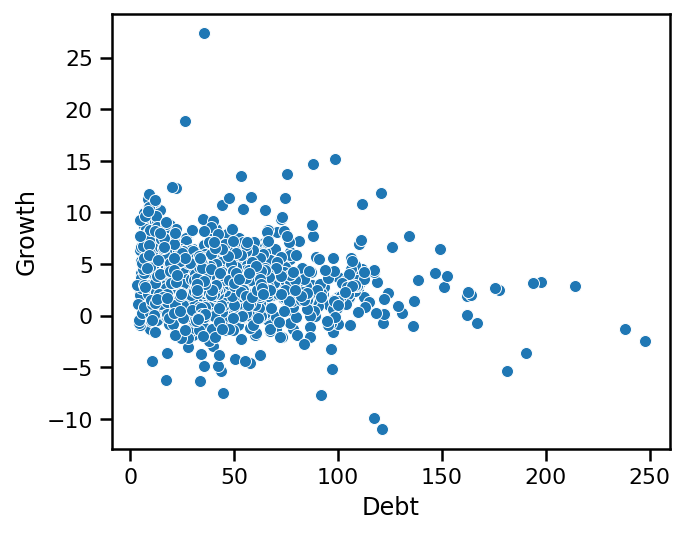

In [221]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# Plot a scatter plot
sns.scatterplot(x="Debt", y="Growth", ax=ax, data=df)

plt.show()

##### Compute r using Scipy<a class="tocSkip"></a>

In [222]:
# Shortcut for our two columns of interest
debt, growth = df["Debt"], df["Growth"]

# Compare it using Scipy
r_, p = stats.pearsonr(debt, growth)
print(f"r={r_}, p={p}")

r=-0.19986576578883178, p=4.723997934448434e-12


Based on this results, I *could* conclude that there is a negative correlation between growth and debt, and that this correlation is statistically significant. However, **this conclusion will be invalid**. Let's see why.

### ...the running example as an example of invalid conclusion

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to compare.
    The growth-debt example is actually an example where conclusions are invalid if using a Pearson Correlation Coefficient, as you'll see below.
 </div>

#### Don't forget to read the doc <a class="tocSkip"></a>

Don't forget to read the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html">doc</a> for knowing of the conditions of application!

<img src="img/doc_cor1.png" width="500" align="left">
<img src="img/doc_cor2.png" width="500" align="left">
<img src="img/doc_cor3.png" width="500" align="left">

We read that:

> The calculation of the p-value relies on the assumption that each dataset is normally distributed.

So, are my conclusions for the growth-debt example valid?

#### Let's check if the conditions for the application for the test are met <a class="tocSkip"></a>

...we need to check the normality of the data.

First thing that we can do is to look at the distribution of each sample.

*Note: In a real context of application, we should have done that at first!*

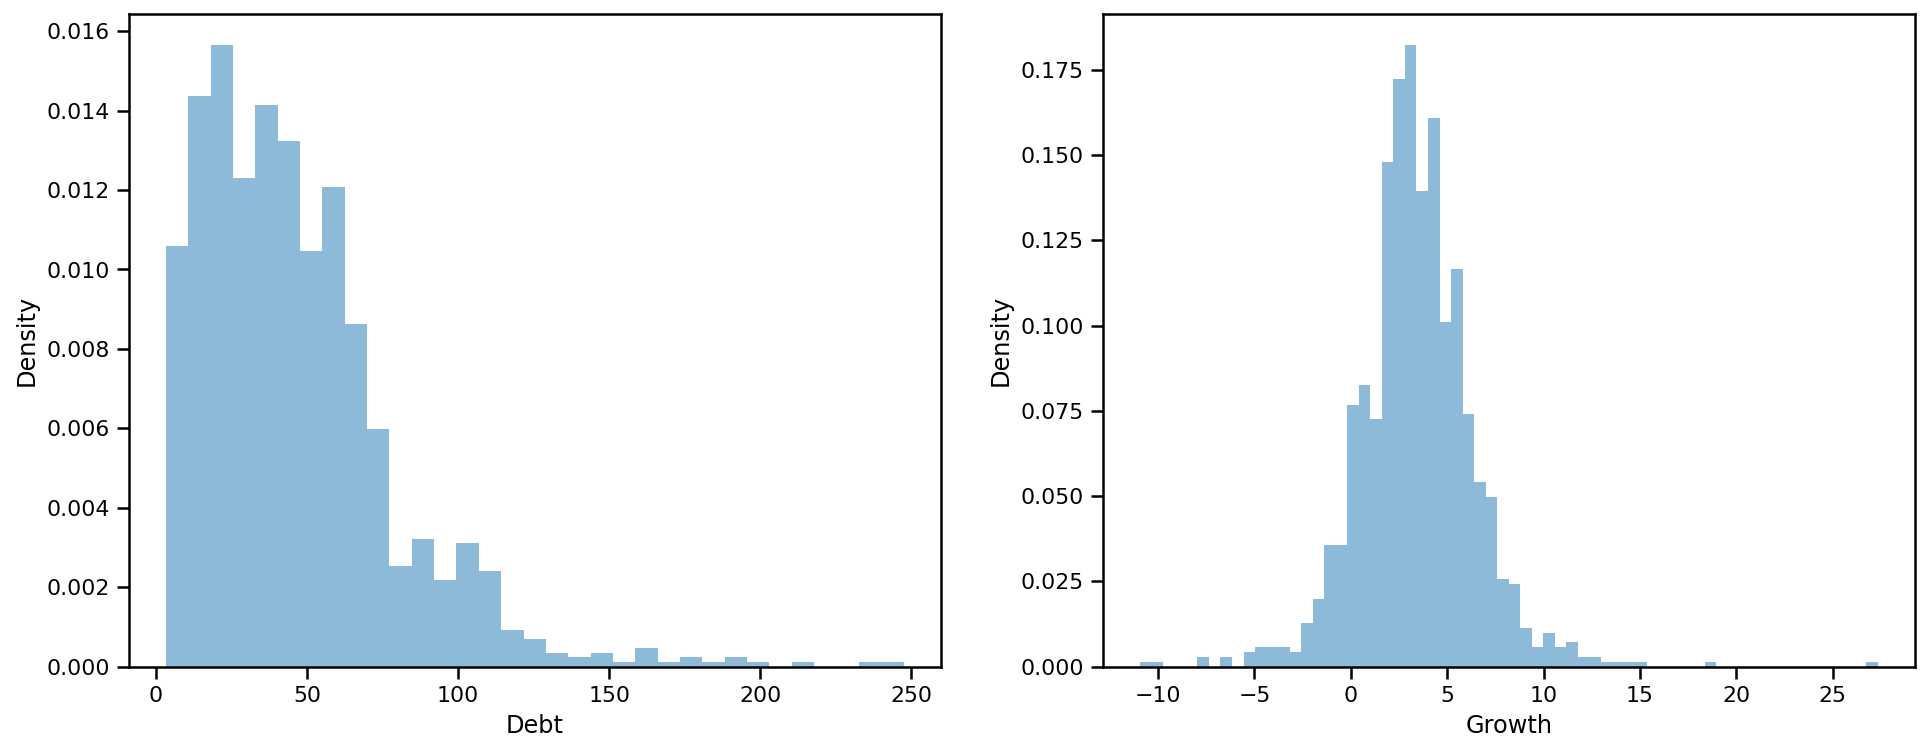

In [223]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the left histogram
sns.histplot(ax=ax1, x=debt, label="debt",
             stat="density",  linewidth=0, alpha=0.5)


# Plot the right histogram
sns.histplot(ax=ax2, x=growth, label="growth",
             stat="density",  linewidth=0, alpha=0.5)
plt.show()

...so are my conclusions valid?


No, they don't seem to be, as the distribution of debt is clearly not normal!

To confirm our observations, let's test the normality of the distribution of both samples (growth and debt) using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [224]:
# Compute the D’Agostino and Pearson’s test for x
k2, p = stats.normaltest(debt)

# Print the result
print(f"debt: k2={k2}, p={p}")

debt: k2=396.2673980743888, p=8.94597806691238e-87


In [225]:
# Compute the D’Agostino and Pearson’s test for y
k2, p = stats.normaltest(growth)

# Print the result
print(f"growth: k2={k2}, p={p}")

growth: k2=183.83634788701923, p=1.2034949429171269e-40


Both indicates that the probability of rejecting the null-hypothesis by error is low: it is unlikely that both samples are normally distributed.

**Therefore, my previous conclusions are invalid.** 

One option is to redo the analysis using a rank-dependent alternative.

### The Spearman correlation coefficient (rank-dependent alternative)

<div class="alert alert-block alert-info">
An rank dependent alternative to the Pearson correlation  is the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html">Spearman correlation coefficient</a>. This test <b>does not</b> require the <b>normality of the parent populations</b>.

</div>

#### Application to the example <a class="tocSkip"></a>

In [226]:
r, p = stats.spearmanr(growth, debt)

print(f"Spearman correlation: r={r}, p={p}")

Spearman correlation: r=-0.21917155435289978, p=3.0218107683321965e-14


I can know conclude, based on the Spearman correlation test, that there is a negative correlation between growth and debt.

## I have only one group: Confidence interval

We are looking for a $c$, such that we can 'bound' the mean, and obtain a confidence interval (CI) such that:
$$\text{CI} = \big(\bar{X} - c,\bar{X} + c\big)$$

They are two main cases: the **standard deviation** from the parent population is **known**, the **standard deviation** from the parent population is **unknown**.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
<br>

Note that for computing a confidence interval in both cases below (SD known, SD unknown), the following conditions about the parent distribution need to be met:

* <b>Normality</b>: The population from which the sample is drawn is normally distributed.
    
</div>

### The population SD is known

...is probably what you're looking for.

The population standard deviation is known (or we have a very large sample, which means we have a reliable estimate of the SD), then: 

$$c = z^{*}{\sigma  \over {\sqrt {n}}}$$
with

$$z^{*}=\Phi ^{-1}\left(1 - \frac{\alpha }{2}\right)$$
where $\Phi^{-1}$ is the [probit function](https://en.wikipedia.org/wiki/Probit) (inverse CDF of the normal distribution), $\alpha$ is the error level (e.g., 5% for a confidence level at 95%).

*Note: This is the most 'classic' formula. However, in practice, it is NOT the formula to use, as, most of the time, we don't know the population standard deviation.*

### The population SD is NOT known

If the population standard deviation is unknown then the Student's $t$ distribution is used as the critical value ($t^*$, see below). 

$$c = t^{*}{s \over {\sqrt {n}}}$$
with $s$ the (sample) standard deviation, $n$ the number of observation.

This value is dependent on the error level ($\alpha$) for the test and degrees of freedom ($\nu = n − 1$). 

$$t^{*}= \text{CDF}_t^{-1}\left(1 - \frac {\alpha }{2}; \nu \right)$$

where $\text{CDF}_t^{-1}$ is the inverse of the CDF of $t$.

### Example 

##### Generate data <a class="tocSkip"></a>

In [227]:
# Seed the random number generator
np.random.seed(12345)

# Generate a sample
x = np.random.normal(100, scale=30, size=30)

# Print a few values
print("x", x)

x [ 93.85877022 114.36830014  84.41683855 ... 115.71316204 100.02820833
 140.31429381]


##### Visualize data <a class="tocSkip"></a>

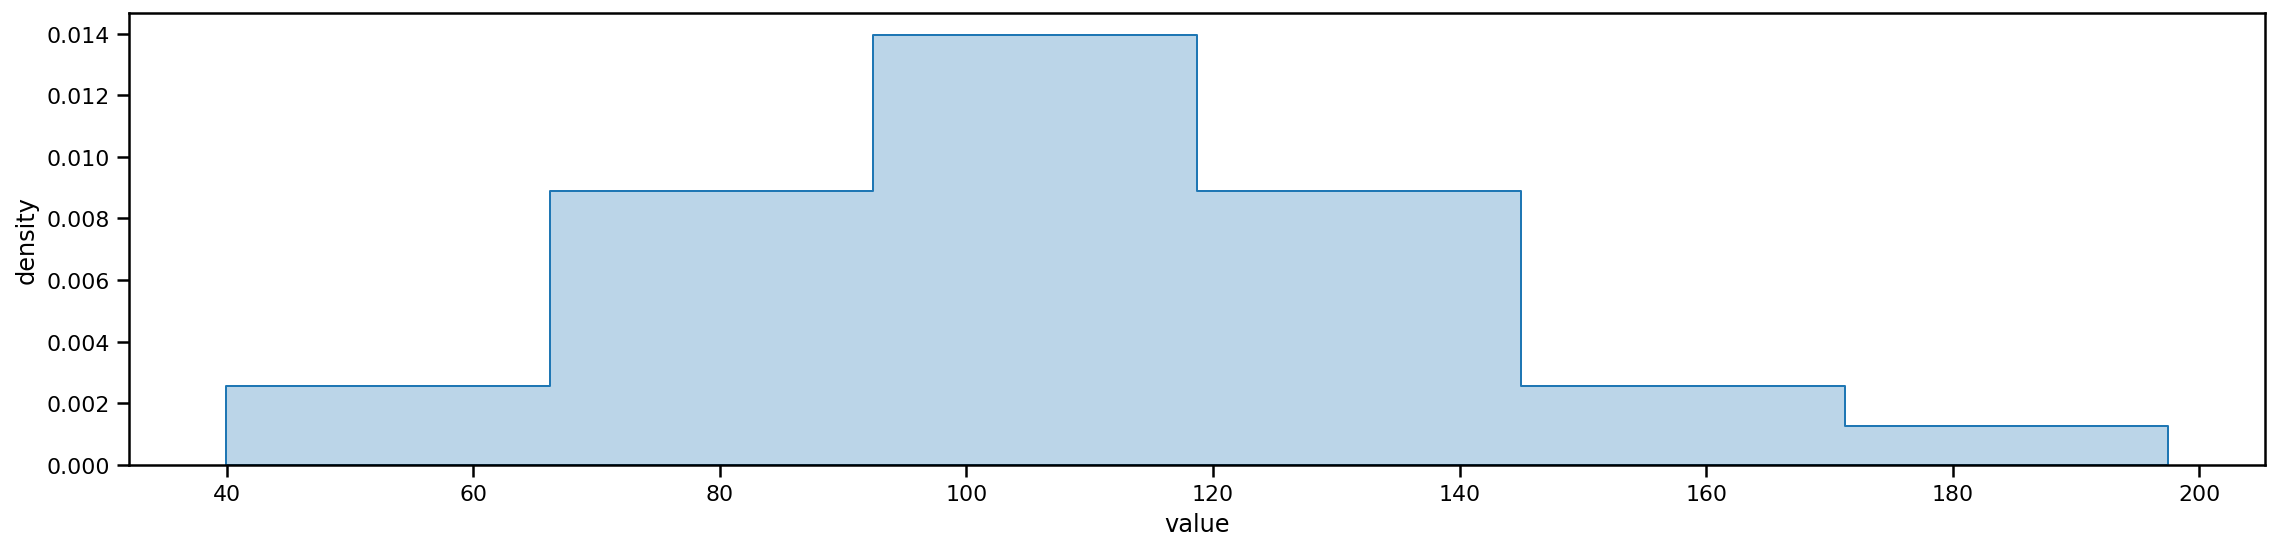

In [228]:
# Create the figure
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x, ax=ax, stat="density", alpha=0.3, element="step")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

##### Compute the CI <a class="tocSkip"></a>

In [229]:
# Set the threshold
alpha = 0.05

# Get the sample size
n = len(x)

# Compute the mean
m = np.mean(x)

# Compute the sd
sd = np.std(x)

# Compute the CDF value at the upper bound
cdf_value_upper_bound = 1 - alpha / 2.

# Compute the number of degrees of freedom
dof = n-1

# Compute t*
# ppf: Percent point function: inverse of the CDF
t_star = stats.t.ppf(cdf_value_upper_bound, dof)  

# Compute the size of half of the confidence interval
c = sd/np.sqrt(n) * t_star 

# Compute the confidence interval
ci = m-c, m+c

# Print the result
print("CI = ", ci)

CI =  (98.45463000700664, 121.83074738449542)


##### Visualize the CI <a class="tocSkip"></a>

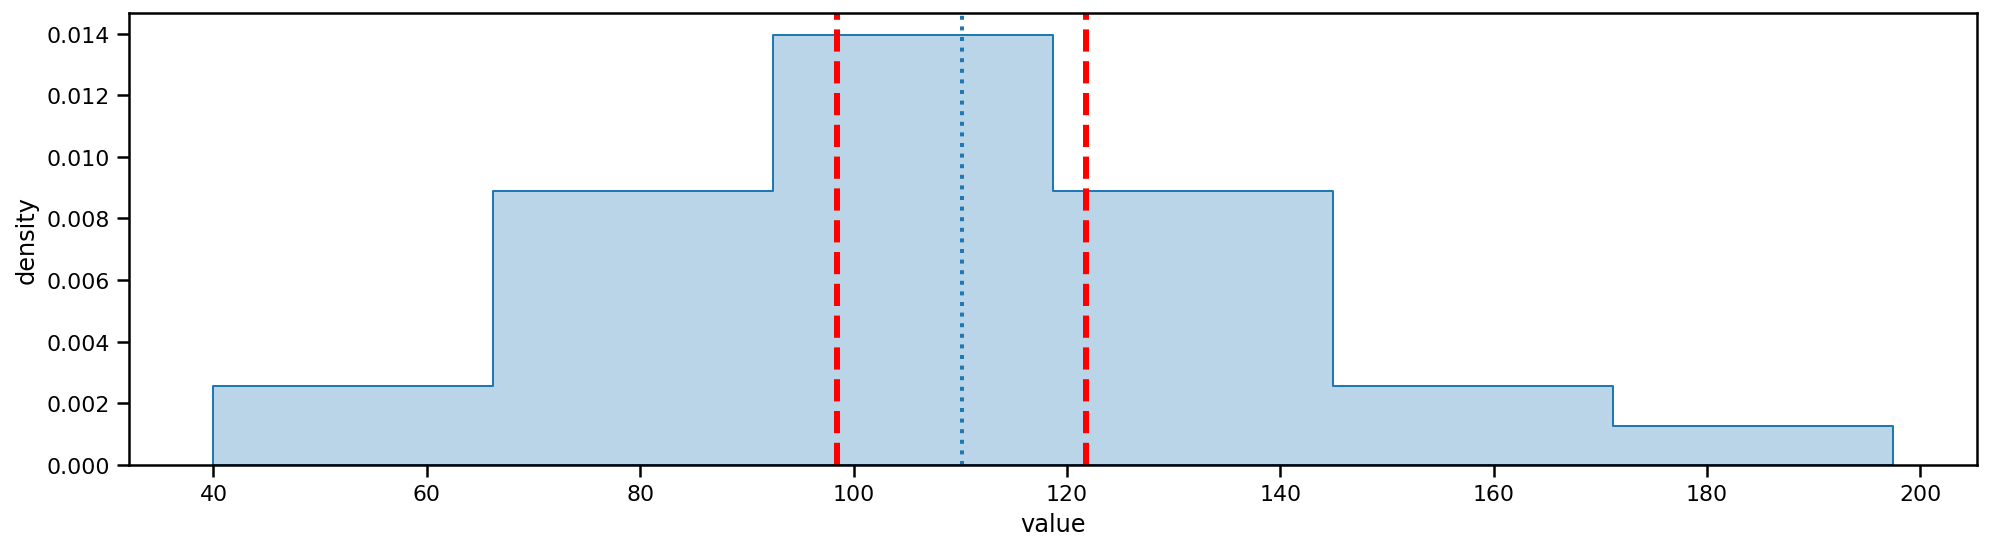

In [230]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the histogram
sns.histplot(x, ax=ax, color="C0", alpha=0.3, stat="density", element="step")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

# Plot the vertical lines
ax.axvline(ci[0], ls="--", color="red", lw=3)
ax.axvline(ci[1], ls="--", color="red", lw=3)
ax.axvline(m, color="C0", lw=2, ls=':')

plt.tight_layout()
plt.show()

### Looking for more? <a class="tocSkip"></a>

They are two sections in the Additional material relating to confidence interval. One is to give an intuition about to find $t^*$. Another is about a bad example of application.

## Another "classic" test: ANOVA

One ultra "classic" test that we will not discuss here is the compare the effect of two factors, you can use an ANOVA (<b>ANalysis Of VAriance</b>). It is useful to discuss the [interaction effects](https://en.wikipedia.org/wiki/Interaction_(statistics)).

Note that for applying an ANOVA, the following conditions about the parent distribution need to be met:

* <b>Normality</b>: The populations from which samples are drawn are normally distributed.

* <b>Homogeneity of variances</b>: The populations from which samples are drawn are approximately equal</b>.

### Looking for more? <a class="tocSkip"></a>

They is one section in the Additional material relating to ANOVA.

# External validity: The todo-NOT list

<div class="alert alert-block alert-info">

1. Do <b>not</b> apply a test before checking its conditions of validity.
    
</div>

(See the growth-debt example as a **bad** example) 

<div class="alert alert-block alert-info">
    
2. Do <b>not</b> think that a **significant** result means that you're sure that there is a **causal** relationship (remember the <a href="http://www.tylervigen.com/spurious-correlations">spurious correlations</a>).
</div>

<img src="img/happy.png" width="500">

<div class="alert alert-block alert-info">

3. Do <b>not multiply</b> the post hoc <b>analysis</b> until you get something <b>significant.</b>
    
</div>

If you need to do multiple comparisons, you need to use a correction on your $p$-values such as a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">Bonferroni correction</a>.

<div class="alert alert-block alert-info">
    
4. Do <b>not</b> think that a <b>non-significant</b> result means that there is <b>no effect</b>: <b>"Absence of evidence is not evidence of absence"</b>.
    
</div>

<img src="img/comics_sign.jpeg" width="500">

# Additional material

## Compare the shape of a t-distribution and a normal distribution

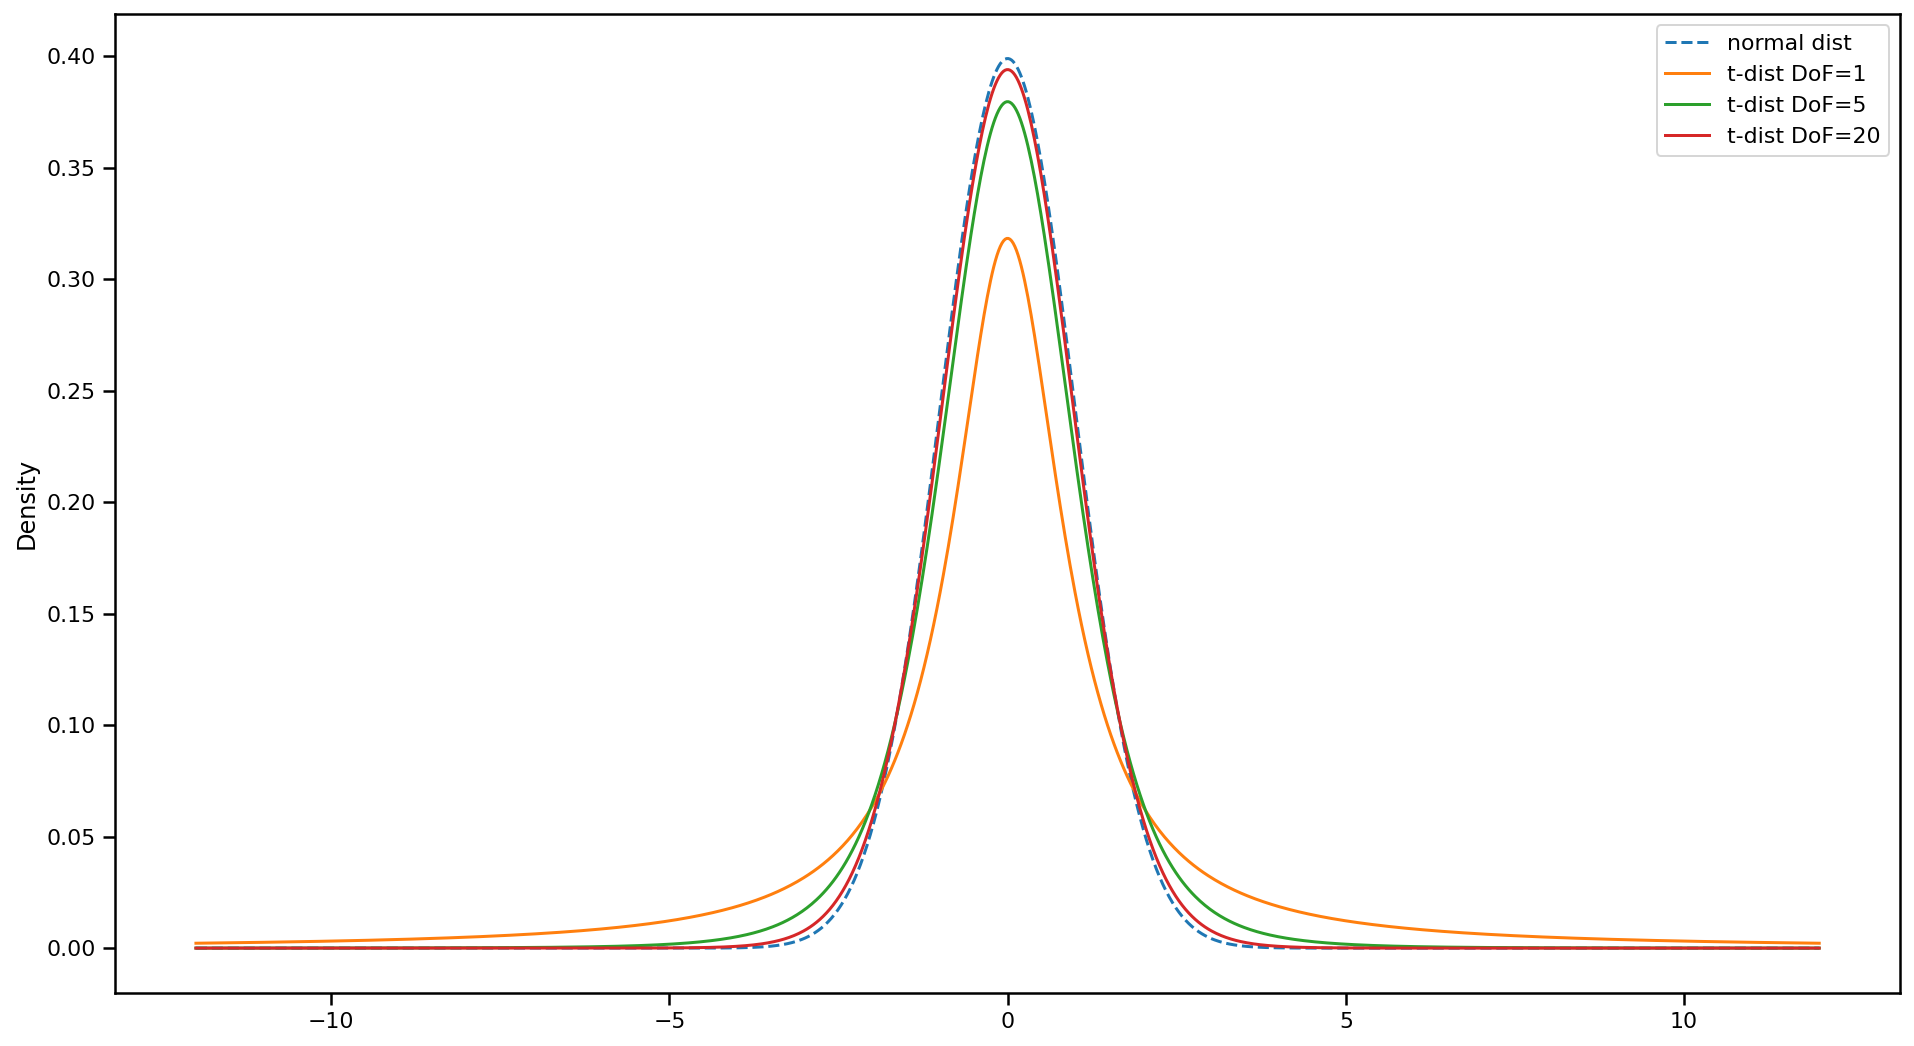

In [231]:
fig, ax = plt.subplots(figsize=(16, 9))

mu = 0
sig = 1

x = np.linspace(-12, 12, 1000)
y1 = stats.norm.pdf(x, loc=mu, scale=sig)
ax.plot(x, y1, label="normal dist", ls="--")

for df in (1, 5, 20):
    y2 = stats.t.pdf(x, loc=mu, scale=sig, df=df)
    ax.plot(x, y2, label=f"t-dist DoF={df}")

ax.set_ylabel('Density')

plt.legend()
plt.show()

## Compare the effect of two factors: ANOVA

I want to compare the effect of two factors, you can use an ANOVA (<b>ANalysis Of VAriance</b>). It is useful to discuss the [interaction effects](https://en.wikipedia.org/wiki/Interaction_(statistics)).

The following conditions about the parent/sample distribution need to be met:

* <b>Normality</b>: The population from which samples are drawn should be normally distributed.

* <b>Homogeneity of variances</b>: The variance among the groups should be approximately equal</b>.

(Bad) Example (see below why it is bad):

In [232]:
# Import the data
df = pd.read_csv("data/stcp-Rdataset-Diet.csv")

# Look at the top of the file
df

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3
...,...,...,...,...,...,...,...
73,74,1,35,183,83,3,80.2
74,75,1,49,177,84,3,79.9
75,76,1,28,164,85,3,79.7
76,77,1,40,167,87,3,77.8


Data from <a href="https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv">https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv</a>

In [233]:
# Print the counts
print(df.count())

Person          78
gender          78
Age             78
Height          78
pre.weight      78
Diet            78
weight6weeks    78
dtype: int64


In [234]:
# Create a new column with the loss of weight
df["Loss"] = df["pre.weight"] - df["weight6weeks"]
df

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks,Loss
0,25,,41,171,60,2,60.0,0.0
1,26,,32,174,103,2,103.0,0.0
2,1,0,22,159,58,1,54.2,3.8
3,2,0,46,192,60,1,54.0,6.0
4,3,0,55,170,64,1,63.3,0.7
...,...,...,...,...,...,...,...,...
73,74,1,35,183,83,3,80.2,2.8
74,75,1,49,177,84,3,79.9,4.1
75,76,1,28,164,85,3,79.7,5.3
76,77,1,40,167,87,3,77.8,9.2


In [235]:
# See the different values for the 'gender' column
print(df["gender"].unique())

[' ' '0' '1']


In [236]:
# Remove the lines when the data is missing
df = df[df["gender"] != ' ']

# Print the new count
print(df.count())

Person          76
gender          76
Age             76
Height          76
pre.weight      76
Diet            76
weight6weeks    76
Loss            76
dtype: int64


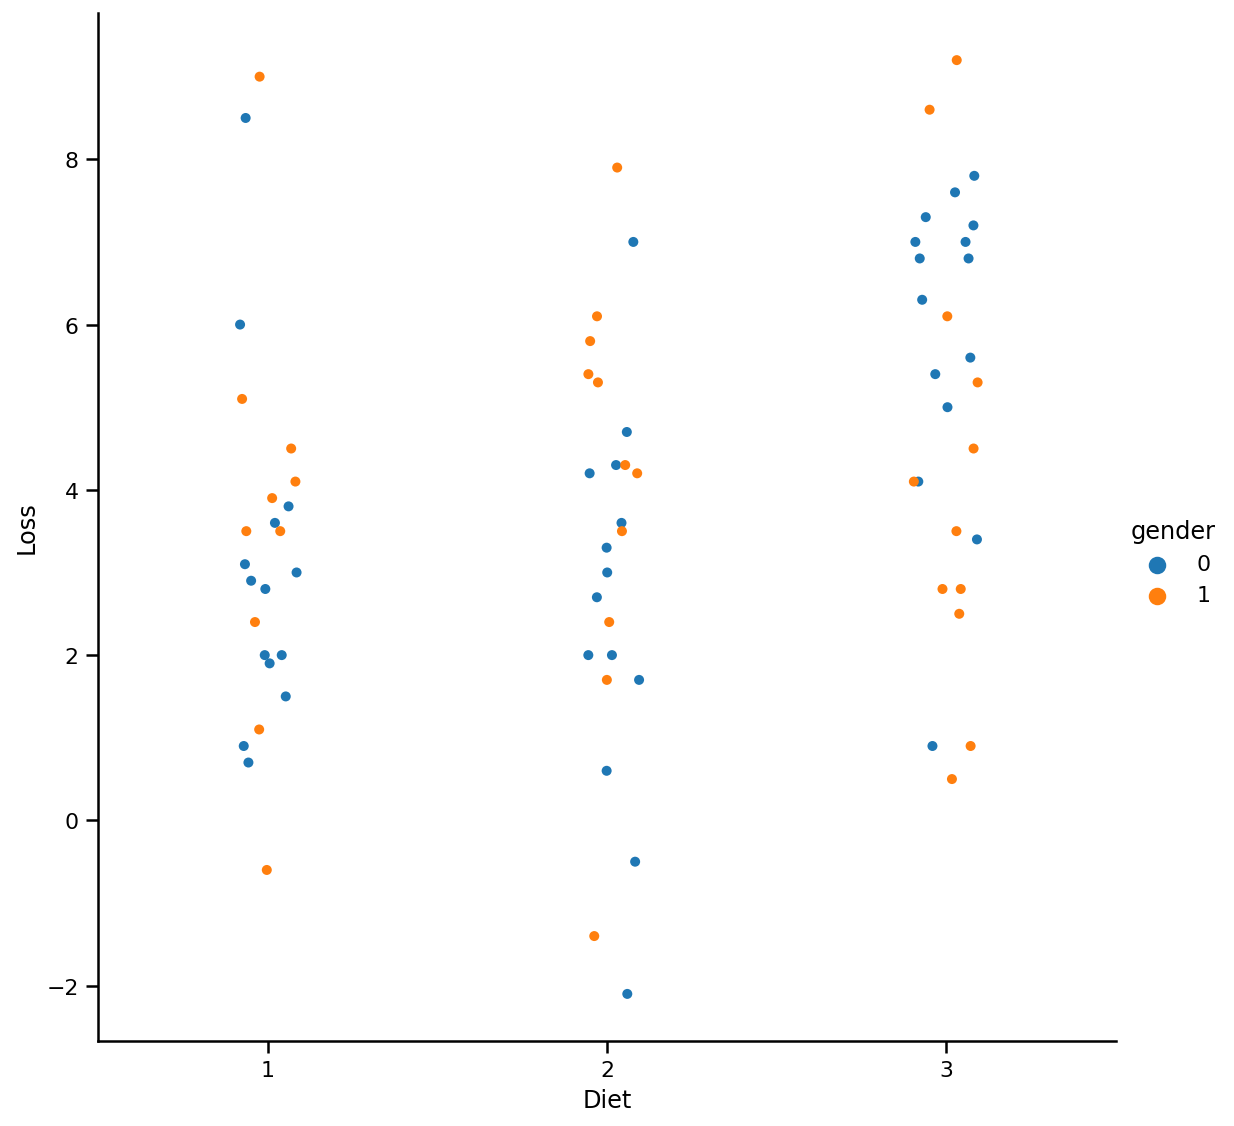

In [237]:
# Represent the raw data
g = sns.catplot(x="Diet", y="Loss", hue="gender",
                data=df, height=8)
plt.show()

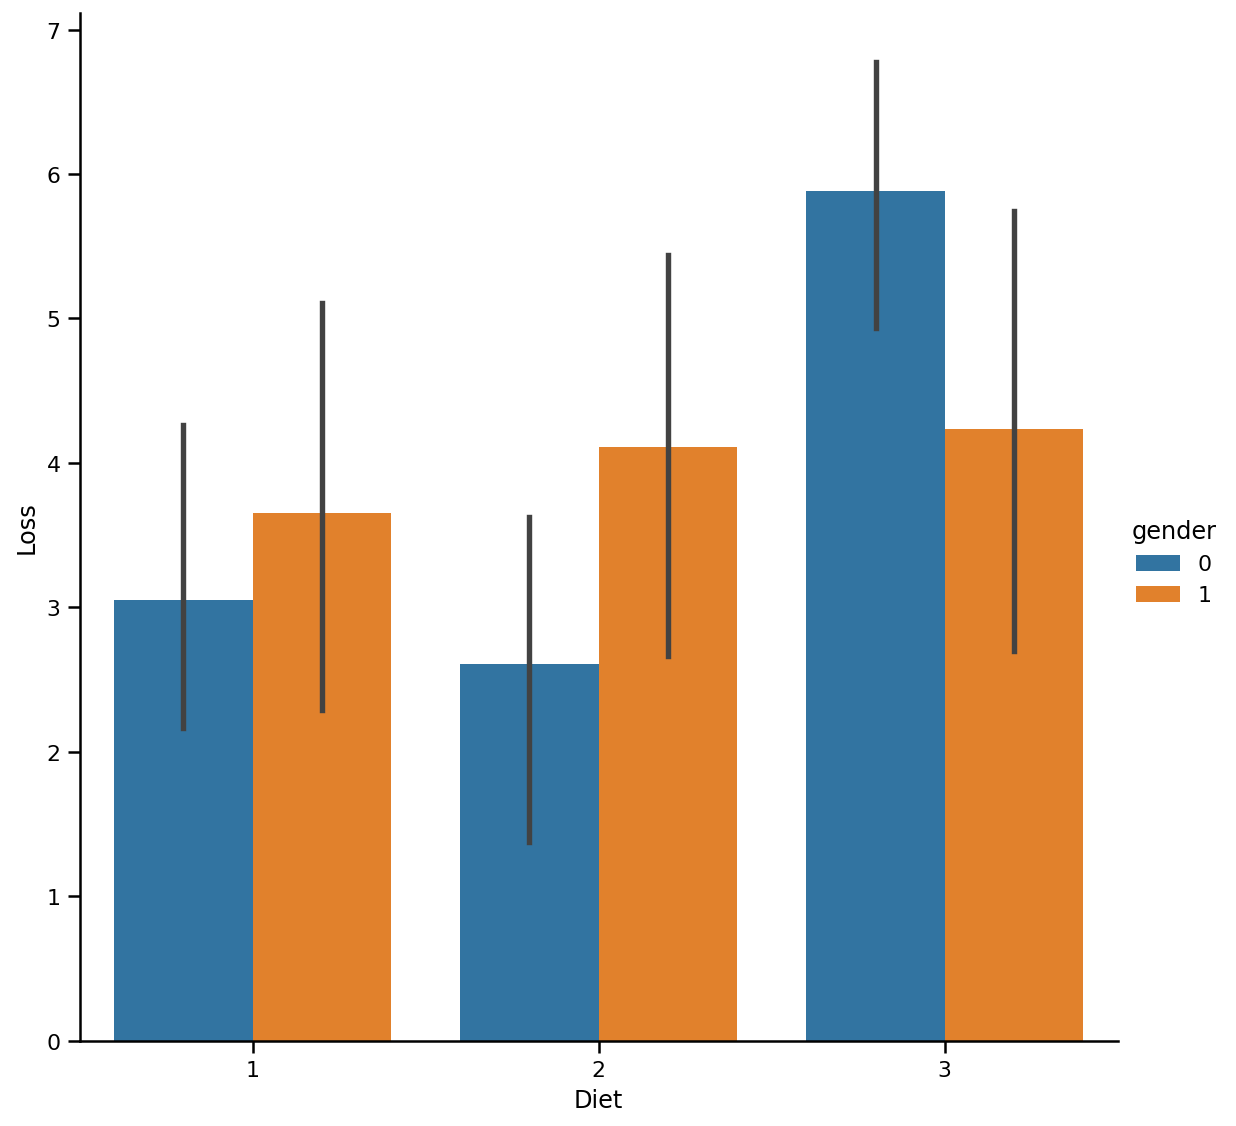

In [238]:
# Use boxplot to synthesize the information
g = sns.catplot(x="Diet", y="Loss", hue="gender",
               data=df, kind="bar", height=8)
plt.show()

In [239]:
# Do an Anova using the statsmodels library
# with the 'loss' as a VD and 'gender' and 'diet' as VI
formula = 'Loss ~ C(Diet) * C(gender)'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)

# Print the result
print(aov_table)

                       sum_sq    df         F    PR(>F)
C(Diet)             60.417220   2.0  5.619026  0.005456
C(gender)            0.168696   1.0  0.031379  0.859910
C(Diet):C(gender)   33.904068   2.0  3.153204  0.048842
Residual           376.329043  70.0       NaN       NaN


---

So, are my conclusions valid?

...we need to check the normality of the data.

Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [240]:
# Boolean for selecting the data such as...
# ...gender = 1
is_g1 = df.gender == "1"
# ...diet = 1
is_d1 = df.Diet == 1

# Compute the D'Agostino and Pearson's test
k2, p = stats.normaltest(df.Diet[is_g1 & is_d1])

# Print the result
print(f"k2={k2}, p={p}")

k2=2122.8650702932387, p=0.0


/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


...unfortunately, our sample is too small. Are my conclusions still valid?

Nope! This was a **bad** example as we can not be sure that the conditions of applications are met. The solution? Using a non-parametric (rank-dependent) test!

## Computing 'by hand' the Mann-Whitney U

### Example <a class="tocSkip"></a>

##### Generate data <a class="tocSkip"></a>

We want data that are not normally distributed. Let's take the example of a gamma distribution (*we could have choose any other one, for instance the beta distribution, this is just an example, it doesn't matter which one we choose, it just does have to be NOT normal*).

So let's consider data following a <a href="https://en.wikipedia.org/wiki/Gamma_distribution">Gamma distribution</a>, that is such that:
$$ X \sim \mathrm{Gamma} (\alpha ,\beta )$$
with $\alpha, \beta \in \mathbb{R}$, two parameters.

*Note: the <a href="https://en.wikipedia.org/wiki/Gamma_distribution">gamma distribution</a> is something different than the gamma function (even if there is a connection: the PDF of the gamma distribution uses the gamma function).*

In [241]:
# Seed the random number generator
np.random.seed(124)

# Set the parameters
# From the doc of 'np.random.gamma': Samples are drawn from a Gamma distribution with specified parameters, 
# shape (sometimes designated “k”) and scale (sometimes designated “theta”), 
# where both parameters are > 0.
# knowing that shape=alpha and theta = 1/beta
k1, t1 = 1, 10
k2, t2 = 1.3, 14
n = 25

# Generate two samples
x1 = np.random.gamma(k1, scale=t1, size=n)
x2 = np.random.gamma(k2, scale=t2, size=n)

# Put it in a dataframe and display
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,1.121221,29.337056
1,13.683424,10.555135
2,8.493649,9.035222
3,6.129344,7.968024
4,4.856549,33.048903
5,3.201905,6.520517
6,11.025071,44.421122
7,5.033123,17.018304
8,3.306910,18.598031
9,15.137628,3.738932


##### Visualize data <a class="tocSkip"></a>

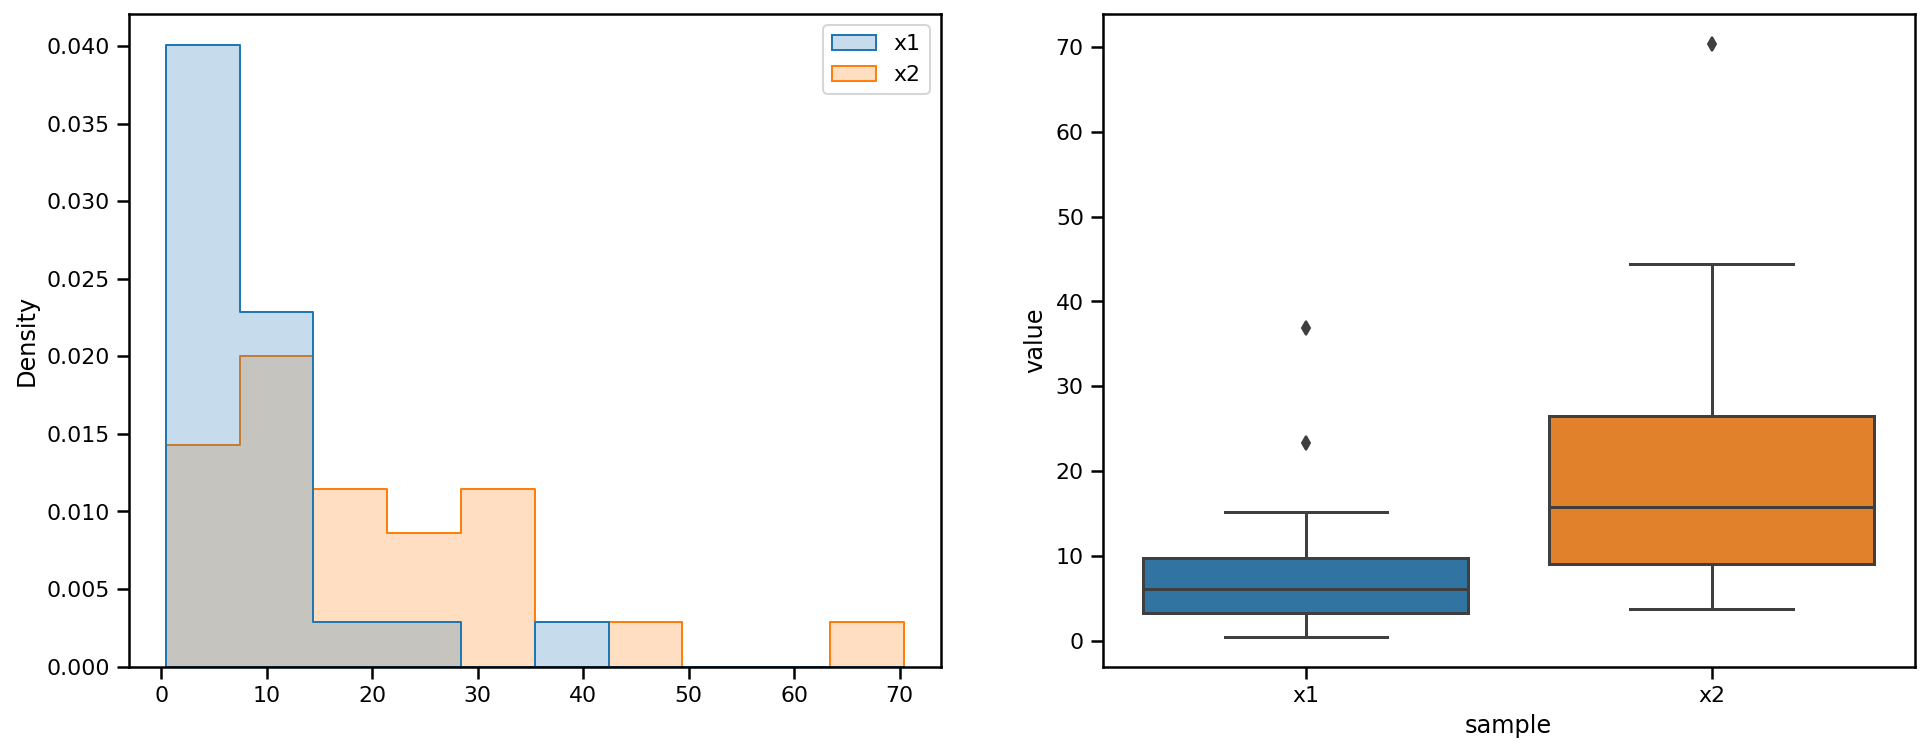

In [242]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the histogram
sns.histplot(data=df, ax=ax1,
             stat="density",
             element="step")

# Plot the boxplot
df_melted = df.melt(var_name="sample")
sns.boxplot(x="sample", y="value", ax=ax2, data=df_melted)

plt.show()

### Computing the Mann–Whitney U with SciPy <a class="tocSkip"></a>

In [243]:
# Compute the Mann-Whitney U
# Note: the default option is deprecated
# Remember to use the argument "alternative='two-sided'"
u, p = scipy.stats.mannwhitneyu(x1, x2, alternative='two-sided')

# Print the results
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


### Computing the Mann–Whitney U by 'hand'<a class="tocSkip"></a>

1. Assign numeric ranks to all the observations (put the observations from both groups to one set), beginning with 1 for the smallest value. Where there are groups of tied values, assign a rank equal to the midpoint of unadjusted rankings. 

Ex: 
* the ranks of (3, 5, 6, 15, 25) are (1, 2, 3, 4, 5)
* the ranks of (3, 5, 5, 5, 5, 8) are (1, 3.5, 3.5, 3.5, 3.5, 6) <i>[note the unadjusted rank would be (1, 2, 3, 4, 5, 6))]</i>.


In [244]:
# Compute the n
n1 = len(x1)
n2 = len(x2)

# Rank the values
ranked = stats.rankdata(np.concatenate((x1, x2)))

# Print the result
print("ranked values", ranked)

ranked values [ 2. 32. 22. ... 45. 50. 31.]


2. add up the ranks for the observations which came from sample 1. The sum of ranks in sample 2 is now determinate, since the sum of all the ranks equals $N(N + 1)/2$ where $N$ is the total number of observations.

$U$ is then given by:

$$U_{1}=R_{1}-{n_{1}(n_{1}+1) \over 2}\,\!$$
where n1 is the sample size for sample 1, and R1 is the sum of the ranks in sample 1.

$$U_{2}=R_{2}-{n_{2}(n_{2}+1) \over 2}\,\!$$

In [245]:
# Get the ranks for the sample x1
rank_x1 = ranked[0:n1]

# Compute U for x1
u1 = n1 * n2 + (n1 * (n1 + 1)) / 2.0 - np.sum(rank_x1, axis=0)

# The remainder is U for x2
u2 = n1 * n2 - u1

# Print the result
print(f"u1 = {u1}; u2 = {u2}")

u1 = 494.0; u2 = 131.0


In [246]:
# Compare with what is obtained using Scipy...
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


#### Compute by hand the p-value of a Mann-Whitney U <a class="tocSkip"></a>

For large samples (n>20), U is approximately normally distributed, with 

$$\mu = \frac {n_{1}n_{2}}{2}$$

$$\sigma^2 = \sqrt {n_1 n_2 (n_1+n_2+1) \over 12}$$
if there is a tie, a correction is necessary:

$$\sigma^2_{\text{corr}}={\sqrt {{n_{1}n_{2} \over 12}\left((n+1)-\sum _{i=1}^{k}{{t_{i}}^{3}-t_{i} \over n(n-1)}\right)}}\,$$

where $n = n_1 + n_2$, $t_i$ is the number of subjects sharing rank $i$, and $k$ is the number of (distinct) ranks.

In [247]:
# Compute the mean of the U distribution
mean_rank = n1*n2/2.0

# Print the result
print("mean_rank", mean_rank)

mean_rank 312.5


In [248]:
# Compute the sd of the U distribution
# Note: we assume that there is not tie here
sd = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0) 

# Print the result
print("sd", sd)

sd 51.53882032022076


In [249]:
# Take the max of U1 and U2
u = max(u1, u2)

# Compute the p-value
p = (1 - stats.norm.cdf(u, loc=mean_rank, scale=sd)) * 2

# Print the result
print("p", p)

p 0.0004289228995439931


In [250]:
# Alternative: compute Z-score first
z = (u - mean_rank) / sd

# Compute the p-value using the Z-score
p = (1 - stats.norm.cdf(z)) * 2
print("p", p)

p 0.0004289228995439931


In [251]:
# Compare with what is obtained using Scipy...
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


In [252]:
# The small difference disappears with 'use_continuity=False' argument
# Indeed, by default, a correction is made assuming data 
# are on a continuous scale
u, p = stats.mannwhitneyu(x1, x2, use_continuity=False, 
                          alternative='two-sided')

# Print the result
print(f"u = {u}, p={p}")

u = 131.0, p=0.00042892289954401424


## Computing by hand a Pearson Coefficient

### Example <a class="tocSkip"></a>

##### Load the data <a class="tocSkip"></a>

In [253]:
# Import the data
df = pd.read_csv(os.path.join("data", "rr.csv"))

# Take a look
df

,Country,Year,Debt,Growth
0,Australia,1946,190.419080,-3.557951
1,Australia,1947,177.321371,2.459475
2,Australia,1948,148.929811,6.437534
3,Australia,1949,125.828699,6.611994
4,Australia,1950,109.809398,6.920201
...,...,...,...,...
1170,US,2005,62.766724,3.054518
1171,US,2006,63.489973,2.672807
1172,US,2007,63.985488,2.141613
1173,US,2008,74.091061,0.438166


Data from <a href="https://pubs.aeaweb.org/doi/pdf/10.1257/aer.100.2.573">Reinhart, C. M., & Rogoff, K. S. (2010). Growth in a Time of Debt. American economic review, 100(2), 573-78.</a>

##### Visualize data <a class="tocSkip"></a>

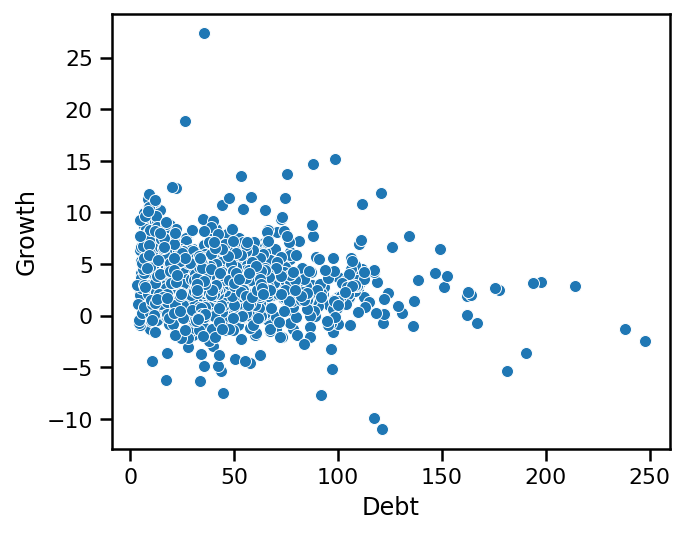

In [254]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# Plot a scatter plot
sns.scatterplot(x="Debt", y="Growth", ax=ax, data=df)

plt.show()

##### Compute r <a class="tocSkip"></a>

In [255]:
# Shortcut for our two columns of interest
debt, growth = df["Debt"], df["Growth"]

# Compare it using Scipy
r_, p = stats.pearsonr(debt, growth)
print(f"r={r_}, p={p}")

r=-0.19986576578883178, p=4.723997934448434e-12


##### Compute r 'by hand' <a class="tocSkip"></a>

In [256]:
# shortcuts
x = debt
y = growth

# Compute the numerator
r_num = np.sum((x - np.mean(x)) * (y - np.mean(y)))

# Compute the denominator
r_denom = np.sqrt(np.sum((x - np.mean(x))**2))*np.sqrt(np.sum((y - np.mean(y))**2))

# Compute the r-value
r = r_num/r_denom

# Print the result
print("r", r)

r -0.19986576578883175


##### Compute the p-value of r 'by hand' <a class="tocSkip"></a>

For computing a p-value, we assume that the coefficient correlation follows a Student's t-distribution. 

We can compute the t-value by using the formula:
$$t=r{\sqrt {\frac {\nu}{1-r^{2}}}}$$
with $\nu = n-2$ the number of degrees of freedom.

Then, we can use the the cumulative distribution function of the t-distribution to compute the p-value.


In [257]:
# Get the n
n = len(x)

# Compute the degrees of freedom
dof = n - 2

# Compute the t-value
t = r * np.sqrt(dof/(1 - r**2))

# Compute the p-value
p = 2 * (1 - stats.distributions.t.cdf(np.abs(t), dof))

# Print the result
print("p", p)

p 4.723998969780041e-12


In [258]:
# Compare with what is obtained using Scipy
r_, p = stats.pearsonr(x, y)
print(f"p={p}")

p=4.723997934448434e-12


<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>

Remember that this is a 'bad' example of application, as neither the distribution of growth, or the distribution or debt can be expected to be normal. The rank-dependent equivalent of the Pearson correlation coefficient should be used instead: the <a href="https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient">Spearman correlation coefficient</a>.
</div>

## Extra information about the confidence interval

Let's come back to the example.

### Example <a class="tocSkip"></a>

##### Generate data <a class="tocSkip"></a>

In [259]:
# Seed the random number generator
np.random.seed(12345)

# Generate a sample
x = np.random.normal(100, scale=30, size=30)

# Print a few values
print("x", x)

x [ 93.85877022 114.36830014  84.41683855 ... 115.71316204 100.02820833
 140.31429381]


##### Visualize data <a class="tocSkip"></a>

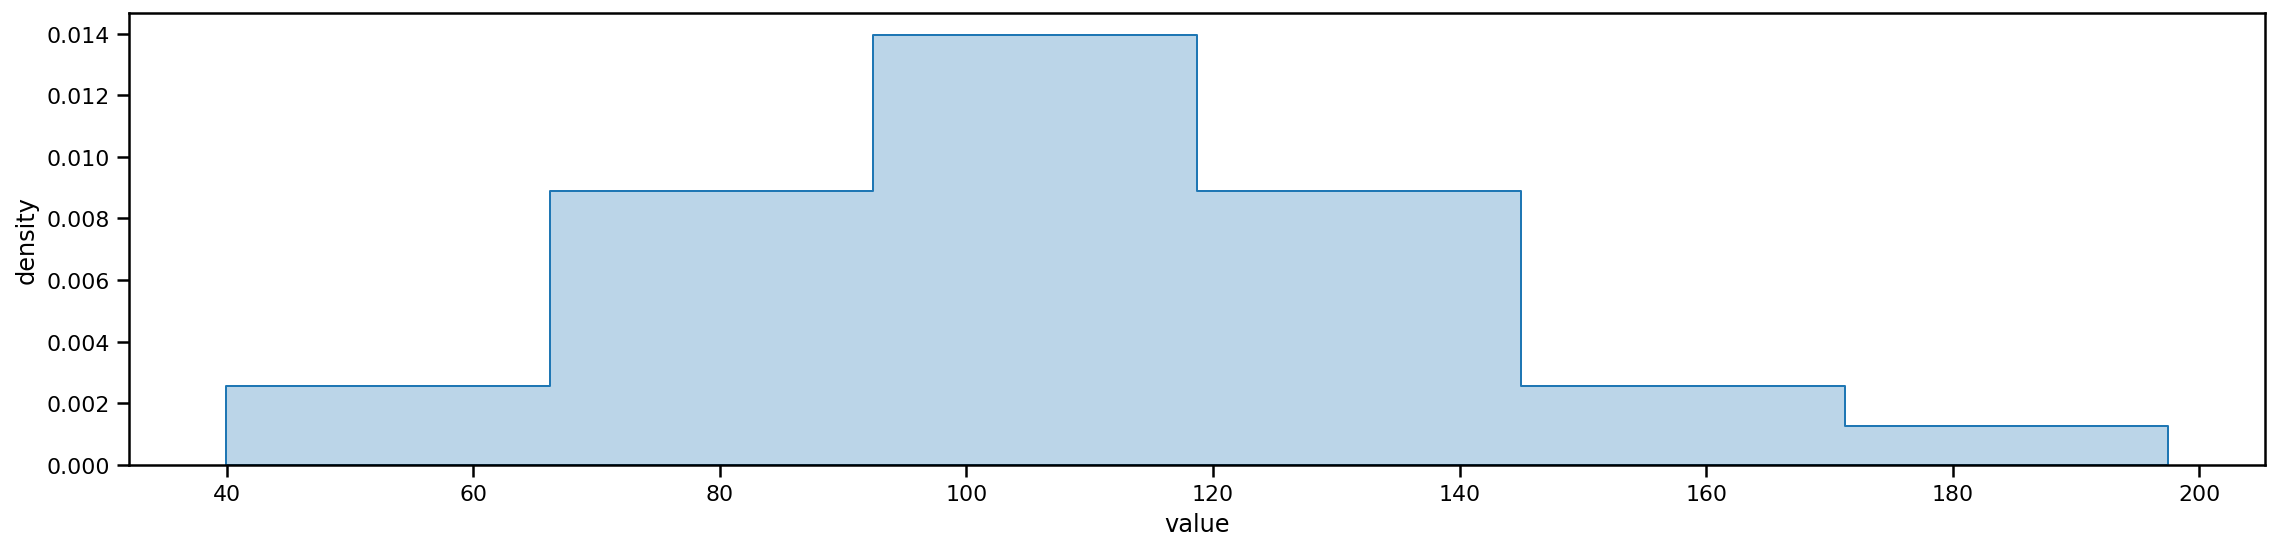

In [260]:
# Create the figure
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x, ax=ax, stat="density", alpha=0.3, element="step")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

##### Compute the CI <a class="tocSkip"></a>

In [261]:
# Set the threshold
alpha = 0.05

# Get the sample size
n = len(x)

# Compute the mean
m = np.mean(x)

# Compute the sd
sd = np.std(x)

# Compute the CDF value at the upper bound
cdf_value_upper_bound = 1 - alpha / 2.

# Compute the number of degrees of freedom
dof = n-1

# Compute t*
# ppf: Percent point function: inverse of the CDF
t_star = stats.t.ppf(cdf_value_upper_bound, dof)  

# Compute the size of half of the confidence interval
c = sd/np.sqrt(n) * t_star 

# Compute the confidence interval
ci = m-c, m+c

# Print the result
print("CI = ", ci)

CI =  (98.45463000700664, 121.83074738449542)


##### Visualize the CI <a class="tocSkip"></a>

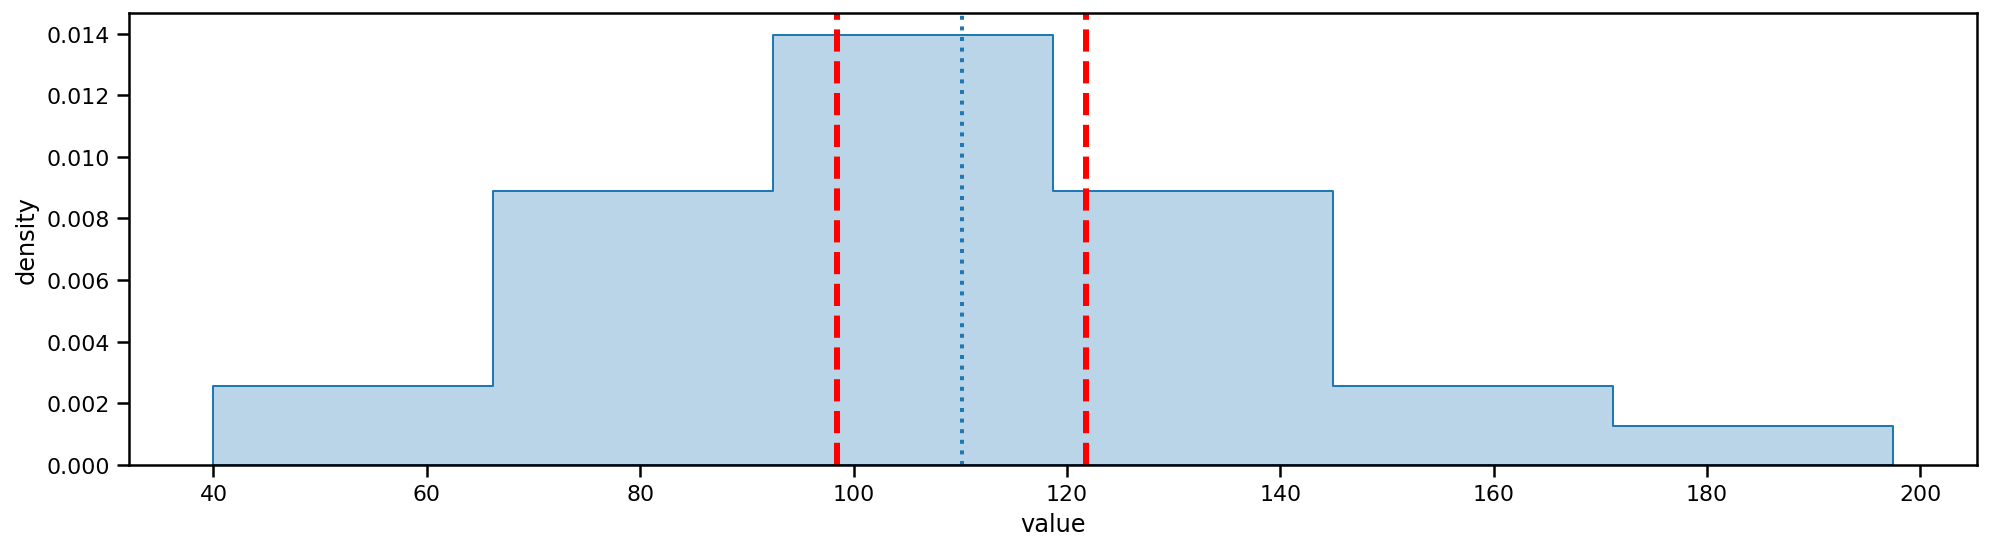

In [262]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the histogram
sns.histplot(x, ax=ax, color="C0", alpha=0.3, stat="density", element="step")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

# Plot the vertical lines
ax.axvline(ci[0], ls="--", color="red", lw=3)
ax.axvline(ci[1], ls="--", color="red", lw=3)
ax.axvline(m, color="C0", lw=2, ls=':')

plt.tight_layout()
plt.show()

Let see try now to have an intuition about how we find the $t^*$.

##### Visualize how to find $t^*$ <a class="tocSkip"></a>

Finding $t^*$ consists in finding for which $t$-value the CDF of the $t$ distribution is equal to $1-\alpha/2$. For computing this, we are using the PPF (percent point function) of the $t$ distribution, which is the inverse of the CDF, but we can 'solve this graphically' just looking at the CDF. So here we go: 

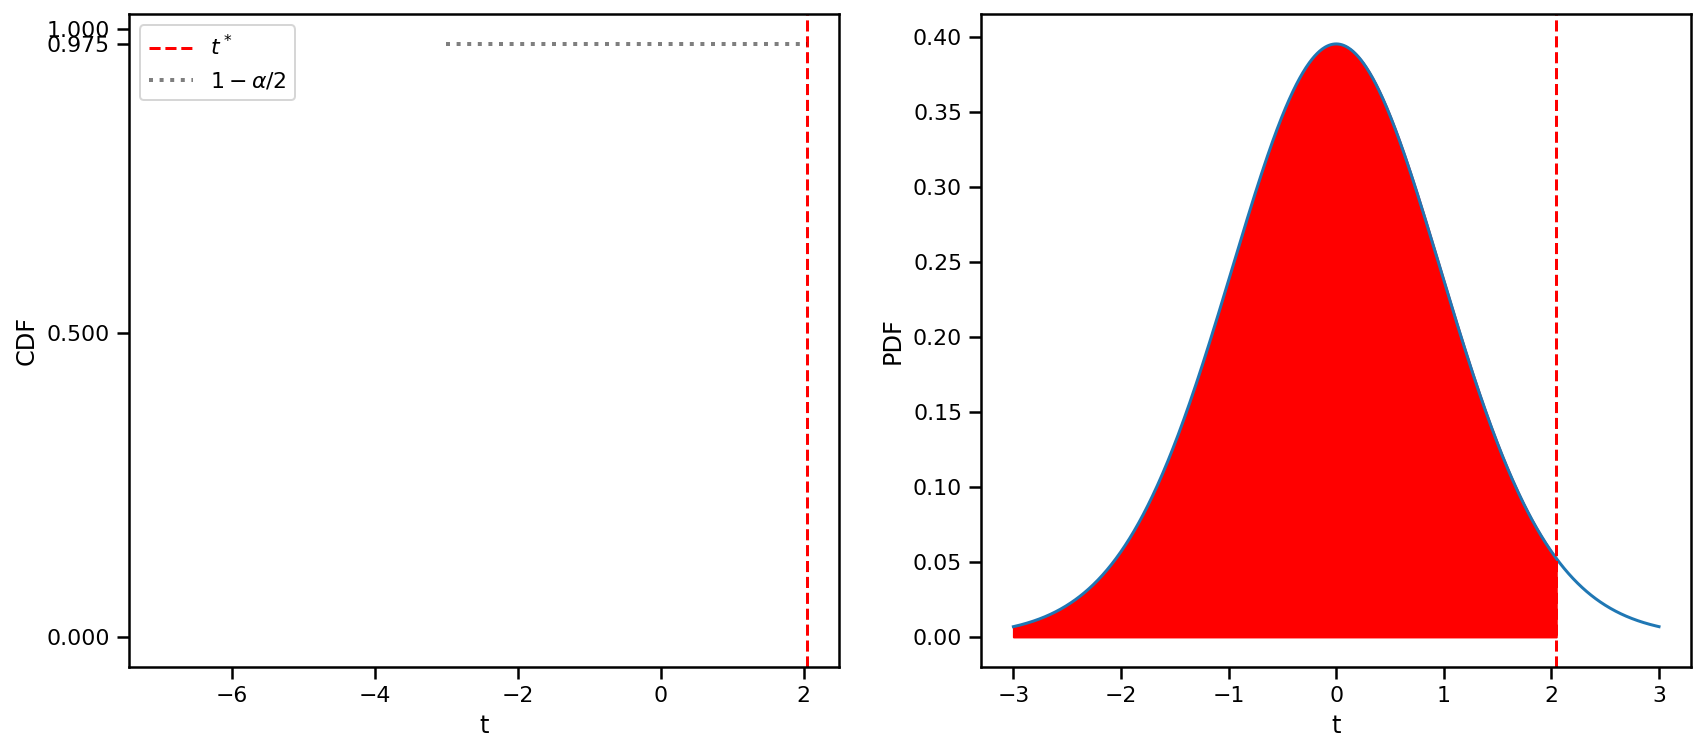

In [263]:
# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Set the range of values
t_min, t_max = -3, 3

ax = axes[0]

# Plot the CDF on the right panel
y2 = stats.t.cdf(t, df=dof)
ax.plot(t, y2, color="red")

# Plot the position of the upper bound
ax.axvline(t_star, ls='--', color="red", label=r'$t^*$')

#. Plot the position of the y-value
ax.plot((t_min,t_star), (1-alpha/2, 1-alpha/2), color="black", alpha=0.5, lw=2, ls=":",
        label=r"$1 - \alpha /2$")
ax.set_yticks([0, 0.5, 1-alpha/2, 1])

# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("CDF")

ax.legend()

ax = axes[1] 

# Plot the bell curve
t = np.linspace(t_min, t_max, 1000) 
y = stats.t.pdf(t, df=dof)
ax.plot(t, y)

# Plot the position fo the upper bounds
ax.axvline(t_star, ls='--', color="red")

# Fill the area under the curve
x_f = np.linspace(t_min, t_star, 1000)
y_f = stats.t.pdf(x_f, df=dof)
ax.fill_between(x_f, 0, y_f, color="red")

# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("PDF")

plt.show()

## An example of bad application of confidence interval: Flight delays.

Let's assume that we are looking for an estimation of the average flight delay, with confidence interval at 95%.

##### Load data <a class="tocSkip"></a>

Let's consider flight arrival delays. Data come from <a href="https://data.world/bob-wakefield/flights">https://data.world/bob-wakefield/flights</a>

In [264]:
# Import the data
df = pd.read_csv("data/flights.csv")

# Print the top of the file
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T05:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T05:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T05:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T05:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T06:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30T14:00:00Z
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,3525,NaN,LGA,SYR,NaN,198,22,0,2013-09-30T22:00:00Z
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,2013-09-30T12:00:00Z
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,2013-09-30T11:00:00Z


In [265]:
# Clean the data set by removing the nan values
x = df.dropna()["arr_delay"].values

##### Visualize data <a class="tocSkip"></a>

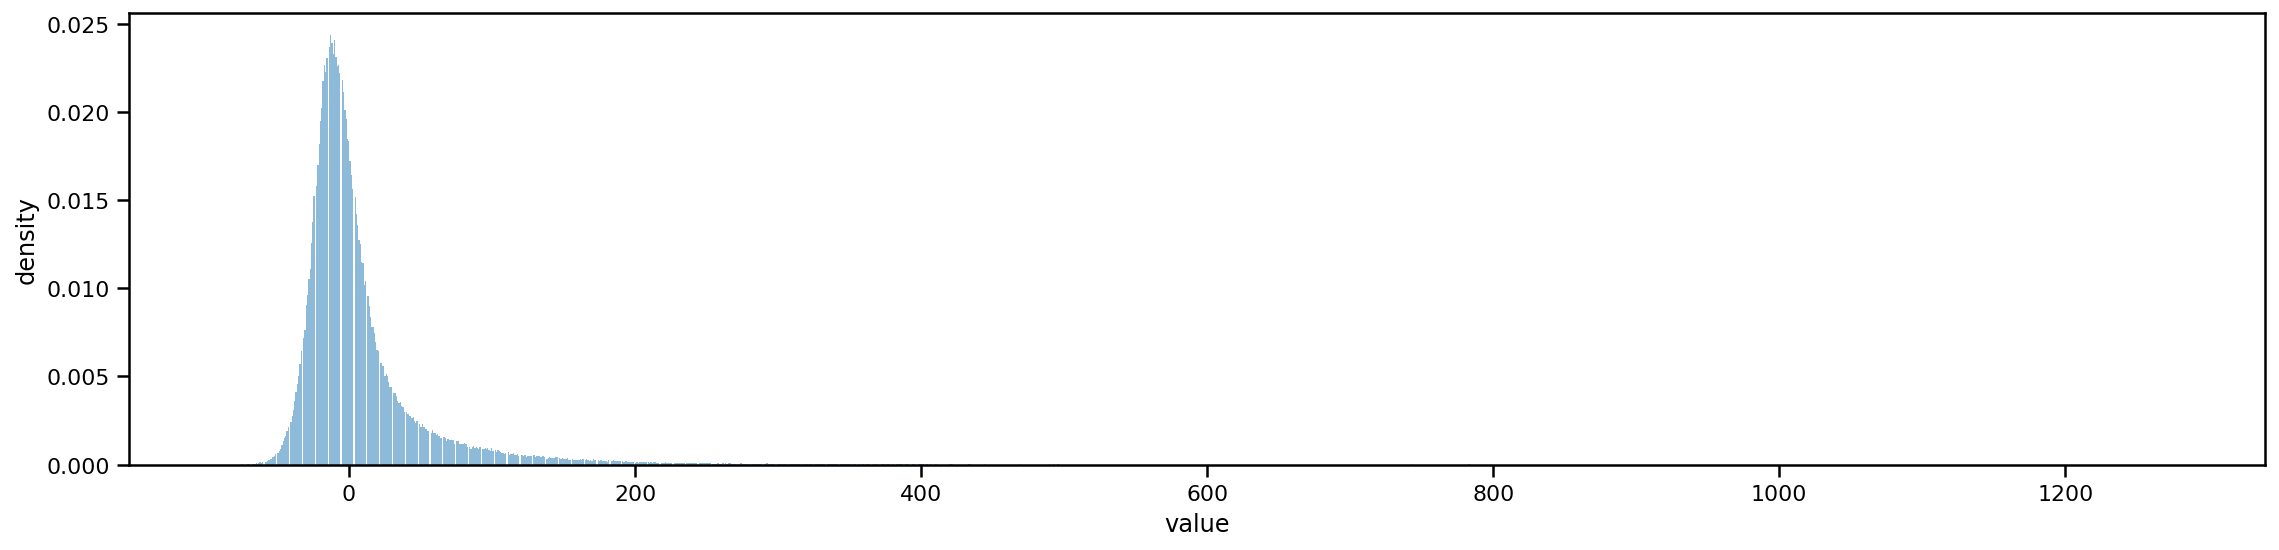

In [266]:
# Create figure and axe
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x="arr_delay", ax=ax, color="C0", linewidth=0, 
             alpha=0.5, stat="density", data=df)

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

Zooming a little bit...

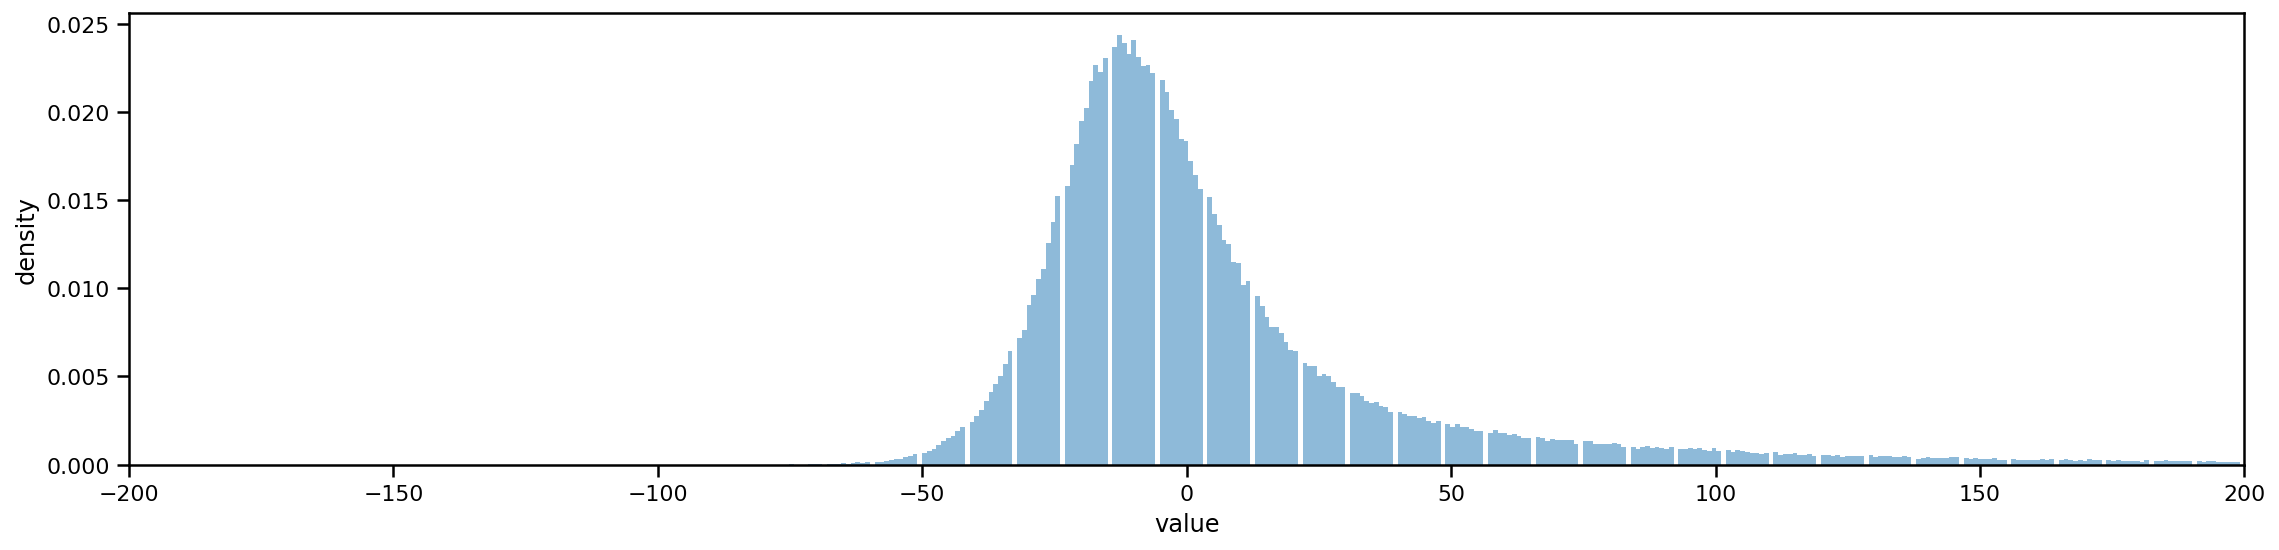

In [267]:
# Create figure and axe
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x="arr_delay", ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density", data=df)

# Set the limits of the x-axis
ax.set_xlim(-200, 200)

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

It doesn't look really like a normal distribution...

##### Check for normality <a class="tocSkip"></a>

Let's check the normality of the data.

For this, we can use a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [268]:
# Compute the D’Agostino and Pearson’s test for our sample
k2, p = stats.normaltest(x)

# Print the result
print(f"k2={k2}, p={p}")

k2=271017.5230787647, p=0.0


The probability to reject the null-hypothesis is close to zero: the data are probability not normally distributed.

...so what should I do?

That's a shame, but just stop here!

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application! Do not forget them to have valid conclusions.
    </div>